![example](images/director_shot.jpeg)

# Microsoft Movie Analysis

**Author:** Hana Kerner
***

## Overview


Microsoft has shown interest in entering the original video content scene, and would like to create a new movie studio. We have been tasked with investigating current and historical trends within the industry to best advise Microsoft on the best route forward. We have used data from IMDB, The Numbers, and Box Office Mojo, while analyzing data from other sources as well. Our method parses through data of over 75,000 movies, and includes cleaning, preapring, and presenting the data using descriptive analysis. The following analysis will use return on investment (ROI) as the main barometer to the measure success of a film. 

The characteristics and trends that we will be forming recommendations around include: 

- Actors
- Directors
- Writers
- Budget 
- Release Month 
- Runtime 
- Studio

## Business Problem

We are looking to create actionable insights for Microsoft pertaining to the attributes of films that will provide the company with the greatest return on investment. 
***
The analysis below aims to answer the following questions:

1. What personnel will generate the greatest return on investment for Microsoft?

Things to consider include:
* Which actors appear most frequently in films with high return? Which directors? Writers?
* Which actors create the highest average return with their films? Directors? Writers?
        
2. What budget bracket is most likely to lead to a high return film?

Things to consider include:
* How does budget relate to worldwide gross?
* Is there a point where return seems to either drop or increase, as budget is increased?

3. What other film attributes have the potential to impact our return?

Things to consider include: 
* How does runtime relate to return? Does this vary much among films?
* How does release month relate to return? Is there a month that is most common for release?
* How does studio relate to return? Does one create superior returns than its counterparts?
***
These questions are crucial in deciding how we will advise Microsoft to move forward, as we will have a better understanding of the industry, and thus, an understanding of what they should focus on to see the greatest possible returns. 

## Data Understanding

We are working movie datasets from 3 separate sources:

1. [Box Office Mojo](https://www.boxofficemojo.com/): each record represents a film, with attributes of that film (e.g. `domestic_gross`). Studio information will be most useful to us here, helping to answer our third question.


2. [IMDB](https://www.imdb.com/): this database contains multiple tables relating to movie attributes, ratings, and personnel. The `movie_basics`, `principals`, `persons`, `directors`, and `writers` tables will all be useful to us in answering our first question. The `movie_basics` table will also help us answer our third question relating to `runtime_minutes`.


3. [The Numbers](https://www.the-numbers.com/): each record represents a film, with attributes of that film (e.g. `production_budget`). The budget and grossing columns are measured in dollars. The `worldwide_grossing` and `production_budget` attributes will be particularly useful to us in creating our ROI column to measure film success. This dataset will help us answer our questions relating to ROI. It will also be useful in answering our second question revolving around the budget, and our third question relating to release month. 

The data above is contained in different formats. The Box Office Mojo data is a compressed CSV (comma-separated-values) file, so below we are able to open it using the `pd.read_csv` function in pandas. We can open The Numbers data using this same method, however, the IMDB is located in a zipped SQLite database. So for that, we unzip, and then query after making the connection to the file using `sqlite3.connect` function in sqlite3. 
***
We also briefly open and look at two other datasets, shown below, but ultimately, the data that these two datasets contain are either repetitive of the data above, or not relevant to our particular analyses. 

[TheMovieDB](https://www.themoviedb.org/)

[Rotten Tomatoes](https://www.rottentomatoes.com/)


***

### Import and Describe Data 
***

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display plot outputs 
%matplotlib inline

In [2]:
# Use pandas function read_csv to open up the file from our zipped folder 
# Use zipped Data folder path and turn into a dataframe to better see file contents

df_bom_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
df_bom_data.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


Next we will use the `.info()` function learn more about the data structure. So far, we can see that this is a dataframe of movies, consisting of their studio, domestic gross, foreign gross, and year. We know we want to analyze if studio has an impact on Return on Investment, so this dataset may be useful for that.

In [3]:
df_bom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


There are 3,387 rows of data here, with 5 columns. Since the Non-Null Count is fewer than 3,387 in the `studio`, `domestic_gross`, and `foreign_gross` columns, we know that we are missing values here. We will be mindful in handling this when it comes to data cleaning. We can see that we have different data types. `title`, `studio`, and `foreign_gross` are objects. `domestic_gross` and `year` are floats and integers, respectively. If we use the `foreign_gross` column, we will want to change its data type to float so we can use it for statistical analyses.

We will continue down the line of our zipped data, next looking at the zipped imdb file.

In [4]:
# We have been instructed to use sqlite to unzip & query this database
# First we will unzip by importing zipfile and extracting the data 

import zipfile
with zipfile.ZipFile("zippedData/im.db.zip", 'r') as zip_imbd:
    zip_imbd.extractall('zippedData')

In [5]:
# We then import sqlite to make the connection to the unzipped file

import sqlite3
conn = sqlite3.connect('zippedData/im.db')

In [6]:
# Safe check to call on the cursor object to see the table names

cur = conn.cursor()

In [7]:
# Execute a query to make sure everything was imported properly and confirm table names 
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")

# Fetch the result and store it in table_names
table_names = cur.fetchall()
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [8]:
# Get a preview of the data from the movie_basics table 

query =  """
SELECT 
* FROM 
movie_basics
"""

movie_basics = pd.read_sql(query, conn) 
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


We can see that this table has the `movie_id`, `primary_title`, `original_title`, `start_year`, `runtime_minutes`, and `genres`. This will be helpful to link to other tables with the `movie_id` key, and helpful to analyze the `runtime_minutes` for our third question and reocommendation. We can already see some null values which we will look at in more depth below. 

In [9]:
# Use .info() method 

movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


This table has 146,144 rows, and 6 columns. We can see that `original_title`, `runtime_minutes`, and `genres` may be missing some values. It looks like the data types are what we would want them to be for each column.

In [10]:
# Preview data from the movie_ratings table 

query =  """
SELECT 
* FROM 
movie_ratings
"""

movie_ratings = pd.read_sql(query, conn) 
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


This table labels the movie by `movie_id` and also has its average rating and the number of votes that each movie received. Since we are not using rating in our analysis, we probably will not use this table. 

In [11]:
# Preview data from the directors table 

query =  """
SELECT 
* FROM 
directors
"""

movie_directors = pd.read_sql(query, conn) 
movie_directors.head()

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


Our first question aims to evaluate the impact that directors and other personnel have on the success of a film, so this table is helpful. The table consits of two columns: `movie_id` and `person_id`. These foreign keys will help us find more detialed information from the other tables within this SQL dataset. Later we will join this table with others to complete a more thorough analysis.

In [12]:
# Use .info() method 

movie_directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


We are not missing any values, and the data type is what we expect. We have more rows than we do in the movie_basics table. This tells us that we have directors who have directed multiple films, or movies with multiple directors.

In [13]:
# Preview data from the persons table 

query =  """
SELECT 
* FROM 
persons
"""

movie_persons = pd.read_sql(query, conn) 
movie_persons.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


This table has data that matches the `person_id` column to `primary_name`. This will be helpful in identifying actor, director, and writer names. The `primary_profession` column is noisy and slightly confusing, so we may be able to get profession information from another table.

In [14]:
# Use .info() method 

movie_persons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


We will only use the `person_id` and `primary_name` columns from this table. These columns are not missing any data, and are object types. Again, we have more rows here than we do in the`movie_basics` table. This makes sense, as it did with the `directors` table, but we will still have to be mindful of it whenn joining tables.

In [15]:
# Preview data from the principals table 

query =  """
SELECT 
* FROM 
principals
"""

movie_principals = pd.read_sql(query, conn) 
movie_principals.head() 

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


The `category` column looks like a much better option (than the `primary_profession` column in the `movie_persons` table) to use and parse through to find the actors and actresses. We note that this table also has `movie_id` and `person_id` which will be keys that we can join our tables on.

In [16]:
# Use .info() method 

movie_principals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   movie_id    1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   person_id   1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


We want to use the `movie_id`, `person_id`, and `category` columns from this table. None of these columns have missing values which is great. When we query this table, we will have to use the SQL `WHERE` clause to specify that we only want rows with data on actors and actresses. 

In [17]:
# Preview data from the writers table 

query =  """
SELECT 
* FROM 
writers
"""

movie_writers = pd.read_sql(query, conn) 
movie_writers.head()

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087


We will want to use this table to investigate information about writers. This table has an identical structure to the `directors` table.

In [18]:
# Use .info() method 

movie_writers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255873 entries, 0 to 255872
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   255873 non-null  object
 1   person_id  255873 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


We are not missing any values, and our data types do not need to be adjusted. We now know all of our information about personnel and runtime is listed in the `IMDB` data. It also has movie title data, which will be helpful to merge on with other datasets. Our `Box Office Mojo` dataset had our studio data. This means we have all of the data we need, except for that of budget and release month. Ideally, one of the datasets below will have both budget and grossing data, that we can use to generate our ROI. We will probably use a release date column to extract release month, so we will look for that in the following datasets as well. 

In [19]:
# Read and open Rotten Tomatoes dataset
# This dataset has tab separated values (.tsv) instead of comma separated (.csv)
# Need to add a delimiter

df_rt = pd.read_csv("zippedData/rt.movie_info.tsv.gz", delimiter="\t")
df_rt.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


This dataframe looks like it will need some cleaning up. There is data on runtime, director, writer, release date, and studio. This is potentially helpful, so we will look at the info below to see if it will add to our analyses, or make it more complicated than necessary. 

In [20]:
# Use .info() method 

df_rt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


We have 1,560 rows with 12 columns. We are missing a lot of data, particularly in the studio, currency, and box_office columns, and would have to change many of the data types. The `Box Office Mojo` dataset has far more information on `studio` than this one. The same is true for that of the `IMDB` datset and the `director`, `runtime` and `writer` columns. The `theater_date` column is potentially helpful, so we will only use this dataset for that if we are unable to find something more comprehensive below. 

In [21]:
# Read and open TMDB dataset

df_tmdb = pd.read_csv("zippedData/tmdb.movies.csv.gz")
df_tmdb.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


This is similar to the `Rotten Tomatoes` dataset in that we would only use the `release_date` column. We will glance at the info below.

In [22]:
# Use .info() method

df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


The data looks good, but is not what we are looking for. We will use the `release_date` column if there is no better option below. 

In [23]:
# Read and open The Numbers dataset

df_tn = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
df_tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


This is exactly what we are looking for. We will be able to merge this with the `IMDB` and `Box Office Mojo` datasets on `movie`. Later we will reset the index and drop the extra `id` column. We now have data on grossing, budget, and release date.

In [24]:
# Use info() method

df_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


We are not missing any values. We will want to change `release_date` to a datetime type, and `production_budget`, `domestic_gross` and `worldwide_gross` to floats. 

## Data Preparation

Now that we have a better understanding of our data and what we will be using it for, we can move onto cleaning the data and preparing it for our analysis. 

***

The main things we will be looking at here inlcude:
* Missing values 
* Duplicate values 
* Data types 
* Creating columns for our `ROI` 
* Creating columns for `release_month`
* Deleting uneccessary data and columns
* Joining SQL tables
* Merging datasets 
* Creating new dataframes to use in our models 

***

We will use the `Box Office Mojo` dataset to answer our third questions which includes analyzing which studio has the potential to bring Microsoft the most value. This dataset will be cleaned, and then merged with `The Numbers` dataset that will eventually include `ROI` data.

We will use the `IMDB` dataset to answer multiple questions. We will clean, filter, and join the SQL tables to provide us with actor, writer, and director information. We will then merge these tables with `The Numbers` data, separately. We will create a separate dataframe to analyze runtime data, again combining data from both the `IMDB`database and `The Numbers`.

We will use `The Numbers` grossing and budget data to create profit and ROI columns. We will then merge this data with the `Box Office Mojo` and `IMDB` data, as mentioned above. We will also able to create new dataframes to explore the release month data and production budget data. 

### Clean the `Box Office Mojo` Dataset

In [25]:
# Check total null values by column

df_bom_data.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

We know we only want to use the `title` and `studio` columns. We will look at the percentage of studio data that we are missing. Seeing as it is only 5 rows, we will likely choose to drop these rows. 

In [26]:
# Create variable to count null studio data
studio_missing = df_bom_data['studio'].isna().sum()

# Create variable to count total rows of data 
bom_length = len(df_bom_data)

# Create variable to calculate percentage of missing studio data 
studio_percentage = (studio_missing / bom_length) * 100
print(studio_percentage, '%')

0.14762326542663123 %


As assumed, this is a very small percentage of the studio data. We will go ahead and delete the 5 missing rows, and create a new dataframe `bom_df`.

In [27]:
 # Use .dropna() to do drop null rows and store it as the new dataframe

bom_df = df_bom_data.dropna(subset = ['studio'])

In [28]:
# Check that the studio column now has 0 null values 

bom_df.isna().sum()

title                0
studio               0
domestic_gross      26
foreign_gross     1349
year                 0
dtype: int64

In [29]:
# Check for any duplicates using duplicated()

bom_df.duplicated('title').any()

True

We have duplicate values, but specified the `title` column in the code above. We will look to see if there are actual duplicates, or if there are multiple movies with the same title.

In [30]:
# Use describe() to look closer at the title column 

bom_df['title'].describe()

count          3382
unique         3381
top       Bluebeard
freq              2
Name: title, dtype: object

We see there are 3,381 unique titles in the dataset, and 3,382 titles in total. We now know there is only one duplicated title, `Bluebeard`, listed twice. We can use the `loc()` function in pandas to access these rows by their label, `Bluebeard`.

In [31]:
# Use .loc() to pull up rows that have 'Bluebeard' as their title

bom_df.loc[bom_df['title'] == 'Bluebeard']

,title,studio,domestic_gross,foreign_gross,year
317,Bluebeard,Strand,33500.0,5200,2010
3045,Bluebeard,WGUSA,43100.0,NaN,2017


These are different films, released in different years. We can see that separate studios produced these films. Since we will be merging this data with `The Numbers` on `title`, we are going to drop these rows as well to limit any confusion where the `studio` and `title` may be incorrectly merged with `budget` and `grossing` values. If there were many cases of this, we likely would not just drop the rows, but since it only occurs once, that is what we will do. 

In [32]:
# Drop rows by index using .drop()

bom_df = bom_df.drop(bom_df[bom_df['title'] == 'Bluebeard'].index)

In [33]:
# Check that this worked using .describe()
# Want to see 3,380 unique values 

bom_df['title'].describe()

count                3380
unique               3380
top       My Soul to Take
freq                    1
Name: title, dtype: object

Great. Now we will drop all columns except for `studio` and `title`.

In [34]:
# Use .drop(), specify axis = 1 to drop columns 

bom_df = bom_df.drop(['domestic_gross', 'foreign_gross', 'year'], axis = 1)

To make our models easier to understand, we will rename the top 20 studios from their abbreviations to full names.

In [35]:
# Count the frequency of studio names
# Sort in descending order of counts 
# Show only top 20

bom_df.groupby('studio').count().sort_values(by='title',ascending=False).head(20)

,title
studio,
IFC,166
Uni.,147
WB,140
Fox,136
Magn.,136
SPC,123
Sony,110
BV,106
LGF,103


Before renaming our top 20, we will use `loc()` to look up abbreviations where we do not know the full studio name. Then we will look at unique studio names using the `unique()` function to see if any abbreviations should be grouped together under the same name. 

In [36]:
# Use .loc() to look up studio abbreviations

bom_df.loc[bom_df['studio'] == 'W/Dim.'].head()

,title,studio
73,Piranha 3D,W/Dim.
146,Youth in Revolt,W/Dim.
398,Scream 4,W/Dim.
405,Spy Kids: All the Time in the World,W/Dim.
470,Apollo 18,W/Dim.


In [37]:
# Look at unique values 

bom_df['studio'].unique()

array(['BV', 'WB', 'P/DW', 'Sum.', 'Par.', 'Uni.', 'Fox', 'Wein.', 'Sony',
       'FoxS', 'SGem', 'WB (NL)', 'LGF', 'MBox', 'CL', 'W/Dim.', 'CBS',
       'Focus', 'MGM', 'Over.', 'Mira.', 'IFC', 'CJ', 'NM', 'SPC', 'ParV',
       'Gold.', 'JS', 'RAtt.', 'Magn.', 'Free', '3D', 'UTV', 'Rela.',
       'Zeit.', 'Anch.', 'PDA', 'Lorb.', 'App.', 'Drft.', 'Osci.', 'IW',
       'Rog.', 'Eros', 'Relbig.', 'Viv.', 'Hann.', 'Strand', 'NGE',
       'Scre.', 'Kino', 'Abr.', 'CZ', 'ATO', 'First', 'GK', 'FInd.',
       'NFC', 'TFC', 'Pala.', 'Imag.', 'NAV', 'Arth.', 'CLS', 'Mont.',
       'Olive', 'CGld', 'FOAK', 'IVP', 'Yash', 'ICir', 'FM', 'Vita.',
       'WOW', 'Truly', 'Indic.', 'FD', 'Vari.', 'TriS', 'ORF', 'IM',
       'Elev.', 'Cohen', 'NeoC', 'Jan.', 'MNE', 'Trib.', 'Rocket',
       'OMNI/FSR', 'KKM', 'Argo.', 'SMod', 'Libre', 'FRun', 'WHE', 'P4',
       'KC', 'SD', 'AM', 'MPFT', 'Icar.', 'AGF', 'A23', 'Da.', 'NYer',
       'Rialto', 'DF', 'KL', 'ALP', 'LG/S', 'WGUSA', 'MPI', 'RTWC', 'FIP',
  

In [38]:
# Create dictionary with current names as keys, new names as values 
# Use replace() and inplace=True to finalize changes

bom_df['studio'].replace({'Uni.':'Universal', 'WB':'Warner Bros.', 'Magn.':'Magnolia', 'SPC':'Sony',
                          'BV':'Walt Disney', 'LGF':'Lionsgate', 'Par.':'Paramount', 
                          'Wein.':'Weinstein Company', 'CL':'Chinese Language', 'FoxS':'Fox', 
                          'RAtt.':'Roadside Attractions', 'KL':'Kino Lorber','P/DW':'Dream Works', 
                            'WB (NL)':'Warner Bros.', 'LG/S':'Lionsgate', 'LGP':'Lionsgate',
                            'ParV': 'Paramount','Sum.':'Summit', 'W/Dim.':'Weinstein Company'}, inplace=True)

In [39]:
# Check this using .head()

bom_df.head()

,title,studio
0,Toy Story 3,Walt Disney
1,Alice in Wonderland (2010),Walt Disney
2,Harry Potter and the Deathly Hallows Part 1,Warner Bros.
3,Inception,Warner Bros.
4,Shrek Forever After,Dream Works


Next, rename the column `title` to `movie`, using the `rename()` function, so that we can merge using this column name later. 

In [40]:
# Use .rename() and assign it to the same variable name 

bom_df = bom_df.rename(columns = {'title' : 'movie'})

In [41]:
# Set the index to movie before merges 

bom_df = bom_df.set_index('movie')

`bom_df` is now clean, and ready to be merged. Now we will clean `The Numbers`.

### Clean `The Numbers` Dataset

We will first check the data for duplicate values. We already know we do not have any null values. We know we want to create new columns for the net profit, ROI, and release month. We will need to change some of our data types to `integer` and `datetime` to be able to do that, and clean up those columns from whitespace and extra characters. 

In [42]:
# Check for any duplicates using .duplicated()

df_tn.duplicated().any()

False

Each column is currently in string format, except for the `id` column. We do not need the `id` column so we will drop it, and then change our data types. 

In [43]:
# Drop 'id' column using .drop()

df_tn = df_tn.drop('id', axis=1)

Change `release_date` column to datetime with `pd.to_datetime`. Assign this to the same column name and check that it worked with `info()`.

In [44]:
# Change data type 

df_tn['release_date'] = pd.to_datetime(df_tn['release_date'])

In [45]:
# Check in 'Dtype 'column'

df_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   movie              5782 non-null   object        
 2   production_budget  5782 non-null   object        
 3   domestic_gross     5782 non-null   object        
 4   worldwide_gross    5782 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 226.0+ KB


Before changing the data types for `production_budget`, `domestic_gross`, and `worldwide_gross`, use `str.replace` to replace the dollar signs and commas with an empty string. Then change to integers using `pd.to_numeric()`.

In [46]:
# Change budget format

df_tn['production_budget'] = df_tn['production_budget'].str.replace('$', '')
df_tn['production_budget'] = df_tn['production_budget'].str.replace(',', '')

In [47]:
# Use the same method to change the format of domestic and worldwide gross

df_tn['domestic_gross'] = df_tn['domestic_gross'].str.replace('$', '')
df_tn['domestic_gross'] = df_tn['domestic_gross'].str.replace(',', '')

df_tn['worldwide_gross'] = df_tn['worldwide_gross'].str.replace('$', '')
df_tn['worldwide_gross'] = df_tn['worldwide_gross'].str.replace(',', '')

In [48]:
# Change the data types to integers

df_tn['production_budget'] = pd.to_numeric(df_tn['production_budget'])
df_tn['domestic_gross'] = pd.to_numeric(df_tn['domestic_gross'])
df_tn['worldwide_gross'] = pd.to_numeric(df_tn['worldwide_gross'])

In [49]:
# Check this using .info()

df_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   movie              5782 non-null   object        
 2   production_budget  5782 non-null   int64         
 3   domestic_gross     5782 non-null   int64         
 4   worldwide_gross    5782 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 226.0+ KB


Now we can create columns from `domestic_net_profit`, `worldwide_net_profit`, `domestic_ROI`, and `worldwide_ROI`. Net profit will be measured as (`gross` - `budget`). This metric can be used as a barometer of success, but we will take it one step further with return on investment. We will use this performance measure to communicate the success of films to Microsoft. Return on investment is calculated by dividing return by cost. For our analyses it will be measured as such: 
***
`Return on Investment` (ROI) = (`worldwide_net_profit` / `production_budget`) * 100
***

We will also calculate the `domestic_ROI`, but will use `worldwide_ROI` as the more comprehensive measure. ROI can be expressed as a percentage or a ratio. For the sake of our analyses, we will multiply our formula by 100 as represent the ROI as a percentage. 

ROI evaluates how well an investment has performed. It is a great metric for making comparisons and ranking investments in different projects. Using ROI to measure success guarantees that we factor in as much information as possible when providing Microsoft with recommendations. We can be confident that we are accurately portraying a film's success, and not blindly advising Microsoft to move forward with prospects that may lose the company more money than it would make. 

One thing to be mindful of is that ROI does not take the factor of `time` into account. This is important because we would not want Microsoft to move forward in producing a film with a massive ROI that will take 30 years to produce. Alternatively, the company could produce 100 films in that same timeframe that would make them far more money overall, even if each film's individual success was only average. We will be mindful of this when discussing our recommendations. 

In [50]:
# Create column for worldwide net profit and domestic net profit

df_tn['worldwide_net_profit'] = (df_tn['worldwide_gross'] - df_tn['production_budget'])
df_tn['domestic_net_profit'] = (df_tn['domestic_gross'] - df_tn['production_budget'])

In [51]:
# Create column for worldwide and domestic ROI 
# remember ROI will be listed here as a percentage 

df_tn['worldwide_ROI'] = ((df_tn['worldwide_net_profit'] / df_tn['production_budget']) * 100)
df_tn['domestic_ROI'] = ((df_tn['domestic_net_profit'] / df_tn['production_budget']) * 100)

In [52]:
# Preview the data 

df_tn.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_net_profit,domestic_net_profit,worldwide_ROI,domestic_ROI
0,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,335507625,553.257713,78.942971
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,-169536125,154.667286,-41.289850
2,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,-307237650,-57.210757,-87.782186
3,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,128405868,324.384139,38.840250
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,303181382,315.369636,95.640815


Now we will go ahead and create a `release_month` column. We will use the `dt.month` function to parse out each specific month from our `release_date` column. This will be listed as a number. To convert these numbers to their respective month name, we will `import calendar` and use a `lambda` function to apply to each value in the new column. 
***
Wrote the function below using `calendar` after looking at the following page on Stack Overflow:
* https://stackoverflow.com/questions/37625334/python-pandas-convert-month-int-to-month-name
***

In [53]:
# Use dt.month() to create new colum 'release_month'

df_tn['release_month'] = df_tn['release_date'].dt.month

In [54]:
# Wrote this function after looking at the following page on Stack Overflow:
# https://stackoverflow.com/questions/37625334/python-pandas-convert-month-int-to-month-name

# Import calendar and use lambda function with .apply()

import calendar
df_tn['release_month'] = df_tn['release_month'].apply(lambda x: calendar.month_name[x])

In [55]:
# Preview the adjusted dataframe

df_tn.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_net_profit,domestic_net_profit,worldwide_ROI,domestic_ROI,release_month
0,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,335507625,553.257713,78.942971,December
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,-169536125,154.667286,-41.289850,May
2,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,-307237650,-57.210757,-87.782186,June
3,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,128405868,324.384139,38.840250,May
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,303181382,315.369636,95.640815,December


This data is almost clean enough to be merged with other datasets. We are first going to glance at the statistics of our numbers using `describe()` and move forward from there. 

In [56]:
# Use .describe() and .apply() to use lambda function to change out of scientific notation 
# Look at production_budget 

df_tn['production_budget'].describe().apply(lambda x: format(x, 'f'))

count         5782.000000
mean      31587757.096506
std       41812076.826943
min           1100.000000
25%        5000000.000000
50%       17000000.000000
75%       40000000.000000
max      425000000.000000
Name: production_budget, dtype: object

Good to see there are not any zero values here. We will look at grossing next.

In [57]:
# Use .describe() and .apply() to use lambda function to change out of scientific notation 
# Look at worldwide_grossing 

df_tn['worldwide_gross'].describe().apply(lambda x: format(x, 'f'))

count          5782.000000
mean       91487460.906434
std       174719968.778905
min               0.000000
25%         4125414.750000
50%        27984448.500000
75%        97645836.500000
max      2776345279.000000
Name: worldwide_gross, dtype: object

The minimum is 0, which means there are films listed with a `worldwide_gross` of zero. This could potentially skew our ROI data to the left, as we know these ROI values will be in the negatives. Let's drop all rows where the `worldwide_gross` is 0. We can do this by creating a new dataframe with the same variable name. We will use the `.loc()` function to specify that we only want to include rows where the value in the `worldwide_gross` column does not equal 0. 

In [58]:
# Create new dataframe using .loc()

df_tn = df_tn.loc[df_tn["worldwide_gross"] != 0]

In [59]:
# Set the index to movie before merges 

df_tn = df_tn.set_index('movie')

The `df_tn` dataframe should now be ready.

The only data we have left to clean is from the `IMDB` database. 

### Clean IMDB Data

For our final dataset we need to explore `actors`, `writers`, `directors`, and `runtime`. We already used SQL queries to look through the tables and determine which ones we will use, and which keys to join on. First, we will join our tables and select the columns that we need. We will then merge our new dataframes with the `df_tn` dataframe that we just finished working with. From there, we will filter out the data we do not need, and create dataframes that we will use for our modeling. 

#### Start with `movie_basics`

We will start by creating and cleaning the `movie_basics` table we looked at above. We will want to glance at the table contents and then use an SQL query to extract the data that we will need to use and create a dataframe. We will merge that dataframe with `tn_df`, and use that new dataframe as our main source of information to work out of. From there, we will explore the `actors`, `directors`, and `writers` data. Finally, we will create a separate dataframe to use when analyzing the `runtime` information. 

In [60]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


We only want `primary_title`, and `runtime_minutes`. We see the `runtime_minutes` column is missing values, and we will handle that later when creating that dataframe. For now, we will check for duplicates and create a new dataframe `imdb_basic` using an SQL query. 

In [61]:
# Check for any duplicates 

movie_basics.duplicated().any()

False

In [62]:
#Create query
q = """
SELECT
    mb.primary_title,
    mb.runtime_minutes
FROM
    movie_basics AS mb
"""

# Use pd.read_sql to create dataframe
imdb_basic = pd.read_sql(q, conn)

# Preview the data
imdb_basic.head()

,primary_title,runtime_minutes
0,Sunghursh,175.0
1,One Day Before the Rainy Season,114.0
2,The Other Side of the Wind,122.0
3,Sabse Bada Sukh,NaN
4,The Wandering Soap Opera,80.0


Rename `primary_title` to `movie` to keep consistent with the other dataframes. Then set the index.

In [63]:
# Rename column
imdb_basic = imdb_basic.rename(columns={'primary_title': 'movie'})

# Reset the index
imdb_basic = imdb_basic.set_index('movie')

#### Create `basics_df`
Merge `df_tn` and `imdb_basic` on `movie`

In [64]:
# Use pd.merge()

basics_df = pd.merge(df_tn, imdb_basic, on='movie')

# Check that this worked
basics_df.head()

,release_date,production_budget,domestic_gross,worldwide_gross,worldwide_net_profit,domestic_net_profit,worldwide_ROI,domestic_ROI,release_month,runtime_minutes
movie,,,,,,,,,,
Avatar,2009-12-18,425000000,760507625,2776345279,2351345279,335507625,553.257713,78.942971,December,93.0
Pirates of the Caribbean: On Stranger Tides,2011-05-20,410600000,241063875,1045663875,635063875,-169536125,154.667286,-41.289850,May,136.0
Dark Phoenix,2019-06-07,350000000,42762350,149762350,-200237650,-307237650,-57.210757,-87.782186,June,113.0
Avengers: Age of Ultron,2015-05-01,330600000,459005868,1403013963,1072413963,128405868,324.384139,38.840250,May,141.0
Avengers: Infinity War,2018-04-27,300000000,678815482,2048134200,1748134200,378815482,582.711400,126.271827,April,149.0


Looks ok so far. We will likely have duplicate values and mismatched values after the merge. We will use `sort_values()` to sort the dataframe by `worldwide_gross` in `descending` order. If there are duplicates, we will use the `loc()` function again to create a new dataframe without these duplicated values. 

In [65]:
# Sort dataframe by worldwide_gross
basics_df = basics_df.sort_values(by=['worldwide_gross'], ascending=False)

# Preview this
basics_df.head(20)

,release_date,production_budget,domestic_gross,worldwide_gross,worldwide_net_profit,domestic_net_profit,worldwide_ROI,domestic_ROI,release_month,runtime_minutes
movie,,,,,,,,,,
Avatar,2009-12-18,425000000,760507625,2776345279,2351345279,335507625,553.257713,78.942971,December,93.0
Titanic,1997-12-19,200000000,659363944,2208208395,2008208395,459363944,1004.104198,229.681972,December,115.0
Titanic,1997-12-19,200000000,659363944,2208208395,2008208395,459363944,1004.104198,229.681972,December,NaN
Avengers: Infinity War,2018-04-27,300000000,678815482,2048134200,1748134200,378815482,582.711400,126.271827,April,149.0
Jurassic World,2015-06-12,215000000,652270625,1648854864,1433854864,437270625,666.909239,203.381686,June,124.0
Furious 7,2015-04-03,190000000,353007020,1518722794,1328722794,163007020,699.327786,85.793168,April,137.0
The Avengers,2012-05-04,225000000,623279547,1517935897,1292935897,398279547,574.638176,177.013132,May,143.0
Avengers: Age of Ultron,2015-05-01,330600000,459005868,1403013963,1072413963,128405868,324.384139,38.840250,May,141.0
Black Panther,2018-02-16,200000000,700059566,1348258224,1148258224,500059566,574.129112,250.029783,February,134.0


As expected, we can already see duplicate values where `Titanic`, `Frozen`, and `Beauty and the Beast` are the index. The entries have different `runtime_minutes` values. We will create a new dataframe called `df_basics`, that only keeps the duplicated entries with the lowest `worldwide_gross`. We will use the tilde bitwise operator for this, which negates the `loc()` statement. So instead of accessing the duplicated entries and marking all duplicates, except for the first, as `True`, and keeping only the first occurrence by index (which we have set to `movie`), it reverses the `True` to `False`. So our new dataframe keeps only the last duplicated index.
***
Wrote `.loc()` function with the help of the following pages on Stack Overflow:
* https://stackoverflow.com/questions/13035764/remove-pandas-rows-with-duplicate-indices
* https://stackoverflow.com/questions/47164362/what-does-a-symbol-do
* https://stackoverflow.com/questions/35939552/pandas-using-the-tilde-operator-to-return-inverse-data-with-two-filters
* https://stackoverflow.com/questions/35939552/pandas-using-the-tilde-operator-to-return-inverse-data-with-two-filters

In [66]:
# Check duplicates

basics_df.duplicated().any()

True

In [67]:
# Wrote this function after looking at the following page on Stack Overflow:
# https://stackoverflow.com/questions/13035764/remove-pandas-rows-with-duplicate-indices

# Use .loc(), tilde, and .duplicated() as mentioned above 
df_basics = basics_df.loc[~basics_df.index.duplicated(keep='first')]

# Check that this worked
df_basics.head(20)

,release_date,production_budget,domestic_gross,worldwide_gross,worldwide_net_profit,domestic_net_profit,worldwide_ROI,domestic_ROI,release_month,runtime_minutes
movie,,,,,,,,,,
Avatar,2009-12-18,425000000,760507625,2776345279,2351345279,335507625,553.257713,78.942971,December,93.0
Titanic,1997-12-19,200000000,659363944,2208208395,2008208395,459363944,1004.104198,229.681972,December,115.0
Avengers: Infinity War,2018-04-27,300000000,678815482,2048134200,1748134200,378815482,582.711400,126.271827,April,149.0
Jurassic World,2015-06-12,215000000,652270625,1648854864,1433854864,437270625,666.909239,203.381686,June,124.0
Furious 7,2015-04-03,190000000,353007020,1518722794,1328722794,163007020,699.327786,85.793168,April,137.0
The Avengers,2012-05-04,225000000,623279547,1517935897,1292935897,398279547,574.638176,177.013132,May,143.0
Avengers: Age of Ultron,2015-05-01,330600000,459005868,1403013963,1072413963,128405868,324.384139,38.840250,May,141.0
Black Panther,2018-02-16,200000000,700059566,1348258224,1148258224,500059566,574.129112,250.029783,February,134.0
Jurassic World: Fallen Kingdom,2018-06-22,170000000,417719760,1305772799,1135772799,247719760,668.101646,145.717506,June,128.0


Now our core data is established, and we can explore the `actors` data.

#### Create and Prepare `df_actors`

We know that we want to use the `category` column in the `movie_principals` table to assemble our next dataframe. First, let's look at exactly what labels the `category` column consists of, and create our query from there. 

In [68]:
# Use .unique() to get list of unique 'category' values 

movie_principals.category.unique()

array(['actor', 'director', 'producer', 'editor', 'actress', 'composer',
       'cinematographer', 'writer', 'self', 'production_designer',
       'archive_footage', 'archive_sound'], dtype=object)

Now we know we will want to include `actor` and `actress` in the `WHERE` clause of our query. Before doing that, let's check for duplicates in the `movie_principals` and `movie_persons` tables.

In [69]:
# Check for duplicates in movie_principals

movie_principals.duplicated().any()

False

In [70]:
# Check for duplicates in movie_persons

movie_persons.duplicated().any()

False

Now we will create an `actors` dataframe that we can merge with `df_basics`. We will use the `movie_id` key to `JOIN` the `principals` and `movie_basics` tables, and the `person_id` key to `JOIN` the `persons` table.

In [71]:
# Create SQL query
q = """
SELECT
    mb.primary_title,
    p.primary_name
FROM
    principals AS pp
JOIN
    movie_basics AS mb USING(movie_id)
JOIN 
    persons AS p USING(person_id)
WHERE 
    pp.category = 'actor'
    OR
    pp.category = 'actress'
"""

# Store in 'actors' dataframe
actors = pd.read_sql(q, conn)

# Preview the dataframe
actors.head()

,primary_title,primary_name
0,A Thin Life,Tommy Dysart
1,The Wicker Tree,Brittania Nicol
2,The Wicker Tree,Henry Garrett
3,The Wicker Tree,Graham McTavish
4,The Wicker Tree,Jacqueline Leonard


Now we rename the `primary_title` column to `movie` and set the index to that column to stay consistent. 

In [72]:
# Rename column 

actors = actors.rename(columns = {'primary_title' : 'movie'})

In [73]:
# Set index 

actors = actors.set_index('movie')

Start by merging `df_basics` with `actors` and create a new dataframe. Then clean it by dropping columns and reordering them.

In [74]:
# Use pd.merge() to create 'df_actors'

df_actors = pd.merge(df_basics, actors, on = 'movie')

In [75]:
# Use .drop() and specify list of columns to drop

df_actors = df_actors.drop(columns = ['release_date', 'worldwide_net_profit',
                                             'domestic_net_profit', 
                                              'release_month', 'runtime_minutes'])

In [76]:
# Use .reindex() to create new column order 

df_actors = df_actors.reindex(columns = ['primary_name', 'worldwide_ROI',
                                                 'domestic_ROI', 'worldwide_gross', 'domestic_gross',
                                     'production_budget'])

In [77]:
# Look at dataframe

df_actors.head()

,primary_name,worldwide_ROI,domestic_ROI,worldwide_gross,domestic_gross,production_budget
movie,,,,,,
Avatar,Mizuki Sashide,553.257713,78.942971,2776345279,760507625,425000000
Avatar,Ai Hashimoto,553.257713,78.942971,2776345279,760507625,425000000
Avatar,Rikako Sakata,553.257713,78.942971,2776345279,760507625,425000000
Avatar,Nako Mizusawa,553.257713,78.942971,2776345279,760507625,425000000
Avatar,Yuri Hane,553.257713,78.942971,2776345279,760507625,425000000


Now let's look into duplicate values in `df_actors`

In [78]:
# Check for duplciates

df_actors.duplicated().any()

True

In [79]:
# Check how many duplicate values we have

df_actors.duplicated().sum()

15

We do not have many duplicates. Let's just use the `drop_duplicates` function to drop these.

In [80]:
# Keep the first duplicated entry

df_actors = df_actors.drop_duplicates(keep = 'first')

In [81]:
# Check this worked

df_actors.duplicated().any()

False

This looks good. We will use an identical process to create `df_directors` and `df_writers`. Once we do this, we will finalize preparing all of our data for modeling. 

#### Create and Prepare `df_directors`

We have already explored the `movie_persons`, and `movie_directors` data so we can skip right into our query. We will create a `directors` dataframe that we can merge with `df_basics`. We will use the `movie_id` key to `JOIN` the `directors` and `persons` tables.

In [82]:
# Create query
q = """
SELECT
    p.primary_name,
    mb.primary_title
FROM
    movie_basics AS mb
JOIN
    directors AS d USING(movie_id)
JOIN 
    persons AS p USING(person_id)
"""

# Create dataframe
directors = pd.read_sql(q, conn)

# Preview
directors.head()

,primary_name,primary_title
0,Harnam Singh Rawail,Sunghursh
1,Harnam Singh Rawail,Sunghursh
2,Harnam Singh Rawail,Sunghursh
3,Harnam Singh Rawail,Sunghursh
4,Mani Kaul,One Day Before the Rainy Season


Looks like we have duplicates. Let's check for these and then delete them.

In [83]:
# Check for duplicates 

directors.duplicated().any()

True

In [84]:
# Drop all duplicates except for first occurence

directors = directors.drop_duplicates(keep='first')

In [85]:
# Check again

directors.duplicated().any()

False

Now we rename the `primary_title` column to `movie` and set the index to that column to stay consistent. 

In [86]:
# Rename `primary_name` column 

directors = directors.rename(columns = {'primary_title' : 'movie'})

In [87]:
# Set that column as index 

directors = directors.set_index('movie')

Start by merging `df_basics` with `directors` and create a new dataframe. Then clean it by dropping columns and reordering them.

In [88]:
# Use pd.merge() to create 'df_directors'

df_directors = pd.merge(df_basics, directors, on = 'movie')

In [89]:
# Use .drop() and specify list of columns to drop

df_directors = df_directors.drop(columns = ['release_date', 'worldwide_net_profit',
                                             'domestic_net_profit', 
                                              'release_month', 'runtime_minutes'])

In [90]:
# Use .reindex() to create new column order 

df_directors = df_directors.reindex(columns = ['primary_name', 'worldwide_ROI',
                                                 'domestic_ROI', 'worldwide_gross', 'domestic_gross',
                                     'production_budget'])

Check for duplicates and preview before moving onto writers

In [91]:
# Check for duplciates

df_directors.duplicated().any()

False

In [92]:
# Preview dataframe

df_directors.head()

,primary_name,worldwide_ROI,domestic_ROI,worldwide_gross,domestic_gross,production_budget
movie,,,,,,
Avatar,Atsushi Wada,553.257713,78.942971,2776345279,760507625,425000000
Titanic,Pete Meads,1004.104198,229.681972,2208208395,659363944,200000000
Titanic,Kevin Lincoln,1004.104198,229.681972,2208208395,659363944,200000000
Titanic,Ravi Punj,1004.104198,229.681972,2208208395,659363944,200000000
Avengers: Infinity War,Anthony Russo,582.711400,126.271827,2048134200,678815482,300000000


#### Create and Prepare `df_writers`

Let's use the same process. Create the query and new dataframe. Then check for duplicates, rename the columns and set the index. Then merge with `df_basics`, drop and reorder the columns, and check for duplicates one final time. 

In [93]:
# Create query
q = """
SELECT
    p.primary_name,
    mb.primary_title
FROM
    movie_basics AS mb
JOIN
    writers AS w USING(movie_id)
JOIN 
    persons AS p USING(person_id)
"""

# Create dataframe
writers = pd.read_sql(q, conn)

# Preview
writers.head()

,primary_name,primary_title
0,Abrar Alvi,Sunghursh
1,Gulzar,Sunghursh
2,Mahasweta Devi,Sunghursh
3,Anjana Rawail,Sunghursh
4,Orson Welles,The Other Side of the Wind


Check and delete duplicate values

In [94]:
# Check for duplicates 

writers.duplicated().any()

True

In [95]:
# Drop all duplicates except for first occurence

writers = writers.drop_duplicates(keep='first')

In [96]:
# Check again

writers.duplicated().any()

False

Now we rename the `primary_title` column to `movie` and set the index to that column to stay consistent.

In [97]:
# Rename `primary_name` column 

writers = writers.rename(columns = {'primary_title' : 'movie'})

In [98]:
# Set that column as index 

writers = writers.set_index('movie')

Start by merging `df_basics` with `writers` and create a new dataframe. Then clean it by dropping columns and reordering them.

In [99]:
# Use pd.merge() to create 'df_writers'

df_writers = pd.merge(df_basics, writers, on = 'movie')

In [100]:
# Use .drop() and specify list of columns to drop

df_writers = df_writers.drop(columns = ['release_date', 'worldwide_net_profit',
                                             'domestic_net_profit', 
                                              'release_month', 'runtime_minutes'])

In [101]:
# Use .reindex() to create new column order 

df_writers = df_writers.reindex(columns = ['primary_name', 'worldwide_ROI',
                                                 'domestic_ROI', 'worldwide_gross', 'domestic_gross',
                                     'production_budget'])

Check for duplicates and preview 

In [102]:
# Check for duplciates

df_writers.duplicated().any()

False

In [103]:
# Preview dataframe

df_writers.head()

,primary_name,worldwide_ROI,domestic_ROI,worldwide_gross,domestic_gross,production_budget
movie,,,,,,
Avatar,Yûsuke Yamada,553.257713,78.942971,2776345279,760507625,425000000
Avatar,Teruo Noguchi,553.257713,78.942971,2776345279,760507625,425000000
Titanic,Kevin Lincoln,1004.104198,229.681972,2208208395,659363944,200000000
Titanic,Ravi Punj,1004.104198,229.681972,2208208395,659363944,200000000
Avengers: Infinity War,Keith Giffen,582.711400,126.271827,2048134200,678815482,300000000


### All of our data cleaning is complete. Now we will go through in question order to prepare our data so it is ready for our models.
***

### Question One - Prepare all Personnel Data

We have our `df_actors`, `df_directors`, and `df_writers` dataframes. We will evaluate each group of people by:

* How frequently they appear in the data
* How frequently they appear in the data limited to the top 25% ROI

* How high their average ROI is per film 
* How high their average ROI is in films limited to the top 25% ROI

***

To do this, we are going to:

* Create a series, consisting of each ROI value in the data, per group
* Create another series, consisting only of people who appear above the 75th percentile of our data by ROI
* Define a function that:
    * Creates a list of people in the `primary_name` column of a specified dataframe
* Create a list of the 10 people per group who appear most often in the top 25% quartile of our data by ROI 
* Create a dataframe to display this frequency 
* Define a function that:
    * Creates a list of corresponding ROI values for a specified list of people in a specified dataframe
* Define a function that: 
    * Creates a dataframe from two specified lists, and sorts the dataframe accordingly 
* Repeat the process for all personnel, not just those above the 75th percentile of our data by ROI
***
This will all be apparent below. For now, that is a brief overview of the process.
***

#### Actors Data Preparation

We will start by creating a `Series` consisting of all of the ROI's listed in the `df_actors` dataframe.   

In [104]:
# Create Series
roi_actors = df_actors['worldwide_ROI']

# Look at statistical overview 
roi_actors.describe()

count    11562.000000
mean       293.260821
std       1279.777007
min        -99.997400
25%        -44.294040
50%         79.209505
75%        282.856075
max      41556.474000
Name: worldwide_ROI, dtype: float64

We can see how widespread our data is, with the bottom 25% of our ROI data in the negatives, while the top 25% of our ROI data brings nearly a 300% return to our stakeholders. For now we are just going to look at the top 25% of the data, and which actors appear most often, as well as generate the highest average ROI within those films. After this, we will look at an overview of the same thing, including all films and not just those with the highest ROI.  

In [105]:
# Create variable that represents the number we will be using to filter our 'worldwide_ROI'
upper_qa = roi_actors.quantile(q = 0.75)

# Create dataframe that only has entries where the ROI is greater than 'upper_qa'
top_actors_df = df_actors[roi_actors > upper_qa]

# Preview the data
top_actors_df.head()

,primary_name,worldwide_ROI,domestic_ROI,worldwide_gross,domestic_gross,production_budget
movie,,,,,,
Avatar,Mizuki Sashide,553.257713,78.942971,2776345279,760507625,425000000
Avatar,Ai Hashimoto,553.257713,78.942971,2776345279,760507625,425000000
Avatar,Rikako Sakata,553.257713,78.942971,2776345279,760507625,425000000
Avatar,Nako Mizusawa,553.257713,78.942971,2776345279,760507625,425000000
Avatar,Yuri Hane,553.257713,78.942971,2776345279,760507625,425000000


Now we will `define a function` that returns a `list` of the `primary_name` of all of the performers who are in a dataframe. We can do this by writing a function that takes in a dataframe, creates an empty list, and loops through a for loop that appends each applicable name to that list.

In [106]:
# Write function that we can use for each group of people 

def top_performers(df):
    
    top_performers = []

    for performer in df['primary_name']:
        top_performers.append(performer)

    return top_performers

Using the `top_performers()` function, we can create a list of top actors by ROI.

In [107]:
# Use new function to create list of top actor names 

top_actors = top_performers(top_actors_df)

Now that we have our list, we want to create a series that consists of actor names, and the amount of times their name appears in the top 25% of our data by ROI. We are going to create a new variable called `top_actor_counts` which will store a `Series` of and `n` quantity of actors and how often their name appears. From that Series, we can create a dataframe called `t25_actor_df`, that contains this data.  

In [108]:
# Create variable 'n' to change head() value if needed 

n = 10

In [109]:
# Create Series that counts the occurence of each actor from the top_actors variable above
top_actor_counts = pd.Series(top_actors).value_counts()

# Store a specified quantity of data in this variable using 'n'
top_actor_counts = top_actor_counts.head(n)

# Preview data 
top_actor_counts

Jennifer Lawrence    9
Dwayne Johnson       9
Kristen Wiig         7
Channing Tatum       7
Anne Hathaway        7
Mark Ruffalo         7
Robert Downey Jr.    7
Zac Efron            6
Michael B. Jordan    6
Rachel McAdams       6
dtype: int64

In [110]:
# Turn into df for easier modeling 

# Reset index 
t25_actor_df = top_actor_counts.reset_index()

# Name columns 
t25_actor_df.columns = ['actors', 'frequency']

# Preview data 
t25_actor_df

,actors,frequency
0,Jennifer Lawrence,9
1,Dwayne Johnson,9
2,Kristen Wiig,7
3,Channing Tatum,7
4,Anne Hathaway,7
5,Mark Ruffalo,7
6,Robert Downey Jr.,7
7,Zac Efron,6
8,Michael B. Jordan,6
9,Rachel McAdams,6


Great. `t25_actor_df` is a dataframe that we are going to use in our plots below. Now we are going to incorporate the `ROI` so we can plot it as well. We are going to create a list of the top ROI's that pair with these actor names. We will store the list version of our `top_actor_counts` Series in a variable called `top_actors`.

In [111]:
# Use .tolist() function to convert the Series of 10 actors to a list on index (actor name)
top_actors = top_actor_counts.index.tolist()

# Preview data
top_actors

['Jennifer Lawrence',
 'Dwayne Johnson',
 'Kristen Wiig',
 'Channing Tatum',
 'Anne Hathaway',
 'Mark Ruffalo',
 'Robert Downey Jr.',
 'Zac Efron',
 'Michael B. Jordan',
 'Rachel McAdams']

Next, we want to `define a function` that takes in a list and dataframe, and returns a list of the `average_ROI` for each person in from the specified list. This function will again create an empty list, and loop through a for loop. The for loop will loop through each name in the `name_list`, and access any occurence where that name exists in the `primary_name` column of the specified `df`. The loop will store those occurences in a variable `loc_performer`. It will then access the `worldwide_ROI` column for each occurrence, use `.mean()` to find the `average_ROI` per `performer`, and return a list of those ROI's, that will correspond to the `name_list`.

In [112]:
# Create function using def()

def average_ROI(name_list, df):
    
    average_ROI = []
    
    for performer in name_list:
        loc_performer = df.loc[df['primary_name'] == performer]
        average_ROI.append(loc_performer.worldwide_ROI.mean())
    
    return average_ROI

Now we can use the `average_ROI` function to create a list of ROI's that correspond with our `top_actors` list. We will use the `top_actors_df` to access this information, and store it in a variable `top_actor_ROI`.

In [113]:
# Use function to create new ROI list
top_actor_ROI = average_ROI(top_actors, top_actors_df)

# Preview list
top_actor_ROI

[704.3510221270828,
 448.0010433787351,
 824.0576010393506,
 764.9647067061117,
 351.1845408005328,
 508.92554594517907,
 439.56293869756007,
 639.4761026921441,
 769.0696337765265,
 440.5935798242424]

Now that we have our two lists with information, we will define our final function to create a dataframe. This function will take in two lists, and the word `True` or `False`. `create_df()` uses the `zip` function and allows us to take two lists and merge them together by creating `tuples`. We then pass this list of tuples into `pd.Dataframe` which takes this new list and converts it into a dataframe. The function stores this dataframe in `df_top`, and then uses the `sort_values()` function to return `df_top` in either `ascending` or `descending` order depending on the `condition` given to the function.
***
Write the function below using `zip()` after looking at the following page on Stack Overflow:
* https://stackoverflow.com/questions/43175382/python-create-a-pandas-data-frame-from-a-list
***

In [114]:
# Wrote the function below after looking at the following page on Stack Overflow:
# https://stackoverflow.com/questions/43175382/python-create-a-pandas-data-frame-from-a-list

# Define create_df function and return df_top

def create_df(name_list, roi_list, condition):
    
    df_top = pd.DataFrame(list(zip(name_list, roi_list)), columns = ['name', 'average_ROI'])
    df_top = df_top.sort_values(by = ['average_ROI'], ascending = condition)
    
    return df_top

Finally, we can use `create_df()` to create a dataframe with the top 10 actors names and their corresponding average ROI's. We will call this `df_top_actors` and we will use this in our plots below. 

In [115]:
# Create df_top_actors in descending order 

df_top_actors = create_df(top_actors, top_actor_ROI, False)
df_top_actors

,name,average_ROI
2,Kristen Wiig,824.057601
8,Michael B. Jordan,769.069634
3,Channing Tatum,764.964707
0,Jennifer Lawrence,704.351022
7,Zac Efron,639.476103
5,Mark Ruffalo,508.925546
1,Dwayne Johnson,448.001043
9,Rachel McAdams,440.593580
6,Robert Downey Jr.,439.562939
4,Anne Hathaway,351.184541


We now have two dataframes filtered by top 25% ROI. The `df_top_actors` dataframe is particularly telling since we used `average_ROI` and tried our best to control for the variance in our data. We will be able to use these two dataframes below to help us best advise Microsoft on profitable personnel. We want to have complete data as well, and not blindly look at the top 25%, so we will repeat this process for all actors, and then for directors and writers. 

#### Repeating Process for All Movies

In [116]:
# Use top_performers() function with df_actors to get list of all actors

all_actors = top_performers(df_actors)

In [117]:
# Create variable storing a Series that counts the frequency of all actors
actor_counts = pd.Series(all_actors).value_counts()

# Store a specified quantity of data in this variable using 'n'
actor_counts = actor_counts.head(n)

In [118]:
# Turn into dataframe and reset index
full_actor_df = actor_counts.reset_index()

# Name columns
full_actor_df.columns = ['actors', 'frequency']

In [119]:
# Use actor_counts Series and turn it into a list 

actor_list = actor_counts.index.tolist()

In [120]:
# Use average_ROI() function to create ROI list 

actor_ROI = average_ROI(actor_list, df_actors)

In [121]:
# Use create_df() function to create dataframe from the two lists created above 
df_actor_ROI = create_df(actor_list, actor_ROI, False)

# Preview dataframe
df_actor_ROI

,name,average_ROI
9,Jennifer Lawrence,464.247970
6,Channing Tatum,372.682713
4,Kevin Hart,357.096088
7,Matthew McConaughey,342.365516
2,Dwayne Johnson,320.470016
1,Steve Carell,283.322444
0,Mark Wahlberg,237.671684
8,Owen Wilson,231.179025
5,Liam Neeson,208.290211
3,Robert De Niro,204.025474


It makes sense that the `average_ROI` per actor in `ALL` of the data is lower than that in just the top 25% ROI of the data. These values are averaged out further by a higher number of films, and potentially worse performing films. We will use this dataframe, as well as `full_actor_df`, which consists of actor counts, in our plots below. We will repeat this process for both `directors` and `writers`.

#### Directors Data Preparation 

We will repeat the process from above, creating `t25_director_df`, `df_top_directors`, `full_director_df`, and `df_director_ROI`

In [122]:
# Store path to worldwide_ROI column in directors_roi variable 

directors_roi = df_directors['worldwide_ROI']

In [123]:
# Store 75th quartile value of 'worldwide_ROI' column in 'upper_dq'
upper_dq = directors_roi.quantile(.75)

# Create dataframe that only has entries where the ROI is greater than 'upper_dq'
top_directors_df = df_directors[directors_roi > upper_dq]

In [124]:
# Use 'top_performers()' function to create list of top director names

top_directors = top_performers(top_directors_df)

In [125]:
# Create Series that counts the occurence of each actor from the top_directors list above 

top_director_counts = pd.Series(top_directors).value_counts()

In [126]:
# Store a specified quantity of data in this variable using 'n'

top_director_counts = top_director_counts.head(n)

In [127]:
# Turn into df for easier modeling 

# Reset index
t25_director_df = top_director_counts.reset_index()

# Name columns
t25_director_df.columns = ['directors', 'frequency']

We have our first directors dataframe in `t25_director_df`. Now let's work on `df_top_directors`

In [128]:
# Use .tolist() function to convert the Series of 10 directors to a list on index (director name)

top_directors = top_director_counts.index.tolist()

In [129]:
# Use ROI function to create list 

director_ROI = average_ROI(top_directors, top_directors_df)

In [130]:
# Use 'create_df()' function to create new dataframe 
df_top_directors = create_df(top_directors, director_ROI, False)

# Preview data
df_top_directors 

,name,average_ROI
3,James Wan,2341.049177
7,Christopher Landon,1577.135927
1,Pierre Coffin,1154.617179
9,David O. Russell,881.860646
2,Tim Story,870.282892
4,Paul Feig,624.402809
8,Will Gluck,588.542456
5,Francis Lawrence,461.386653
0,Steven Spielberg,385.326336
6,Christopher Nolan,340.136893


In [131]:
# Use .loc() to see top values

top_directors_df.loc[top_directors_df['primary_name'] == 'James Wan']

,primary_name,worldwide_ROI,domestic_ROI,worldwide_gross,domestic_gross,production_budget
movie,,,,,,
Furious 7,James Wan,699.327786,85.793168,1518722794,353007020,190000000
Aquaman,James Wan,616.809150,109.413629,1146894640,335061807,160000000
The Conjuring,James Wan,1490.000705,587.000705,318000141,137400141,20000000
Insidious,James Wan,6558.059067,3500.610000,99870886,54009150,1500000


Great. `df_top_directors` is our second dataframe to plot. Now we look at all director data instead of just that of the top 25% ROI.

In [132]:
# Use top_performers() function with df_directors to get list of all directors

all_directors = top_performers(df_directors)

In [133]:
# Create variable storing a Series that counts the frequency of all directors
director_counts = pd.Series(all_directors).value_counts()

# Store a specified quantity of data in this variable using 'n'
director_counts = director_counts.head(n)

In [134]:
# Turn into dataframe and reset index
full_director_df = director_counts.reset_index()

# Name columns
full_director_df.columns = ['directors', 'frequency']

`full_director_df` is our third dataframe here. Now onto `df_director_ROI`.

In [135]:
# Use director_counts Series and turn it into a list 

director_list = director_counts.index.tolist()

In [136]:
# Use average_ROI() function to create ROI list 

director_ROI = average_ROI(director_list, df_directors)

In [137]:
# Use create_df() function to create dataframe from the two lists created above 
df_director_ROI = create_df(director_list, director_ROI, False)

# Preview dataframe
df_director_ROI

,name,average_ROI
3,Steven Soderbergh,591.433308
9,David O. Russell,522.931922
1,Tim Story,515.386184
5,David Gordon Green,369.134514
4,Jon M. Chu,364.833485
0,Steven Spielberg,269.389714
2,Clint Eastwood,256.024094
7,Ridley Scott,200.638682
8,Denis Villeneuve,132.845301
6,Peter Berg,56.064214


That was our final director dataframe. Now we repeat the process for `writers` before moving onto `Question 2`.

#### Writers Data Preparation 

This time we are creating `t25_writer_df`, `df_top_writers`, `full_writer_df`, and `df_writer_ROI`

In [138]:
# Store path to worldwide_ROI column in writers_roi variable 

writers_roi = df_writers['worldwide_ROI']

In [139]:
# Store 75th quartile value of 'worldwide_ROI' column in 'upper_wq'
upper_wq = writers_roi.quantile(.75)

# Create dataframe that only has entries where the ROI is greater than 'upper_wq'
top_writers_df = df_writers[writers_roi > upper_wq]

In [140]:
# Use 'top_performers()' function to create list of top writer names

top_writers = top_performers(top_writers_df)

In [141]:
# Create Series that counts the occurence of each actor from the top_writers list above 

top_writer_counts = pd.Series(top_writers).value_counts()

In [142]:
# Store a specified quantity of data in this variable using 'n'

top_writer_counts = top_writer_counts.head(n)

In [143]:
# Turn into df for easier modeling 

# Reset index
t25_writer_df = top_writer_counts.reset_index()

# Name columns
t25_writer_df.columns = ['writers', 'frequency']

We have our first writers dataframe in `t25_writer_df`. Now let's work on `df_top_writers`

In [144]:
# Use .tolist() function to convert the Series of 10 writers to a list on index (writer name)

top_writers = top_writer_counts.index.tolist()

In [145]:
# Use ROI function to create list 

writers_ROI = average_ROI(top_writers, top_writers_df)

In [146]:
# Use 'create_df()' function to create new dataframe 
df_top_writers = create_df(top_writers, writers_ROI, False)

# Preview data 
df_top_writers

,name,average_ROI
2,Oren Peli,3192.181229
5,Christopher Landon,2989.085407
8,M. Night Shyamalan,2253.227776
9,Linda Woolverton,641.201299
7,Suzanne Collins,532.891046
6,Michael Arndt,437.962425
3,Larry Lieber,411.525156
1,Stan Lee,408.055855
0,Jack Kirby,404.261869
4,Joe Simon,397.262382


In [147]:
# Use .loc() to see top values

top_writers_df.loc[top_writers_df['primary_name'] == 'Larry Lieber']

,primary_name,worldwide_ROI,domestic_ROI,worldwide_gross,domestic_gross,production_budget
movie,,,,,,
Avengers: Infinity War,Larry Lieber,582.711400,126.271827,2048134200,678815482,300000000
Iron Man 3,Larry Lieber,507.696136,104.496136,1215392272,408992272,200000000
Thor: Ragnarok,Larry Lieber,370.544458,75.032383,846980024,315058289,180000000
Thor: The Dark World,Larry Lieber,329.735011,37.574760,644602516,206362140,150000000
Ant-Man and the Wasp,Larry Lieber,379.342046,66.652877,623144660,216648740,130000000
Ant-Man,Larry Lieber,299.121884,38.617048,518858449,180202163,130000000


Great. `df_top_writers` is our second dataframe to plot. Now we look at all writer data instead of just that of the top 25% ROI.

In [148]:
# Use top_performers() function with df_writers to get list of all writers

all_writers = top_performers(df_writers)

In [149]:
# Create variable storing a Series that counts the frequency of all writers
writer_counts = pd.Series(all_writers).value_counts()

# Store a specified quantity of data in this variable using 'n'
writer_counts = writer_counts.head(n)

In [150]:
# Turn into dataframe and reset index
full_writer_df = writer_counts.reset_index()

# Name columns
full_writer_df.columns = ['writers', 'frequency']

`full_writer_df` is our third dataframe here. Now onto `df_writer_ROI`.

In [151]:
# Use writer_counts Series and turn it into a list 

writer_list = writer_counts.index.tolist()

In [152]:
# Use average_ROI() function to create ROI list 

writer_ROI = average_ROI(writer_list, df_writers)

In [153]:
# Use create_df() function to create dataframe from the two lists created above 
df_writer_ROI = create_df(writer_list, writer_ROI, False)

# Preview data
df_writer_ROI

,name,average_ROI
5,Guillermo del Toro,695.599317
4,Larry Lieber,366.761016
1,Stan Lee,308.887359
8,Christopher Markus,305.114083
9,Stephen McFeely,305.114083
0,Jack Kirby,300.976459
3,Luc Besson,268.353211
2,Nicholas Stoller,157.270352
6,John Logan,121.043263
7,William Shakespeare,61.783328


That was our final writer dataframe. Now we are ready to answer `Question 1`, so we move to `Question 2` preparation.

### Question Two - Prepare all Budget Data

We have our `df_tn` dataframe. We will evaluate the `production_budget` by:

* How does budget relate to worldwide gross?
* How does budget relate to the highest grossing films? Lowest?
* How does the difference in budget categories impact gross?

***

To do this, we are going to:

* Split our grossing data by looking at the top and bottom 500 values sorted by worldwide gross
* Create budget bins from the top 500 grossing films 
* Use budget as a categorical variable 

***
Since all of our ROI data is dictated by `production_budget`, we will only use our grossing data in our budget evaluation. As a reminder, our ROI formula subtracts budget from gross, and then divides that net profit by budget. 
***

First, we will create two dataframes. One that has the top 500 grossing films, and another that has the lowest 500 grossing films. This will help us determine how impactful budget is to gross, right off the bat. We will sort `df_tn` by `worldwide_gross`, and assign the highest 500 values to `top_budget`, and the lowest 500 values to `bottom_budget`.

In [154]:
# Sort values in descending order and select the first 500 values by index
top_budget = df_tn.sort_values(by = 'worldwide_gross', ascending = False)[:500]

# Sort values in ascending order and select the first 500 values by index
bottom_budget = df_tn.sort_values(by = 'worldwide_gross', ascending = True)[:500]

We will use these two dataframes in our models below. We know we want to take a deeper dive into the highest grossing films, and create bins from that data, so we will look closer at the numbers in `top_budget`.

In [155]:
# Use lambda function to remove scientific notation
# Use .describe() to return statistical overview of 'top_budget'

top_budget.production_budget.describe().apply(lambda x: format(x, 'f'))

count          500.000000
mean     115383645.238000
std       68111568.037002
min        3900000.000000
25%       65000000.000000
50%      110000000.000000
75%      160000000.000000
max      425000000.000000
Name: production_budget, dtype: object

We can see how large the standard deviation is here. With that confirmed, it may be helpful to separate our data into categories that we can compare in box and whisker and bar plots. To do this, we will create 4 separate ranges that our budget values will fall into. Out of the 500 highest grossing films, our `Low` bin will consits of the bottom `25-50%` of budget data, our `Middle` bin will consist of the `50-75%` percentile of our budget data, our `Top` bin will consist of the `75-95%` percentile of our budget data, and finally our `Top 5%` bin will consist of the top `5%` of our budget data.
***
Wrote the function below using `pd.cut()` with the following help from Stack Overflow:
* https://stackoverflow.com/questions/49382207/how-to-map-numeric-data-into-categories-bins-in-pandas-dataframe
***

In [156]:
# Wrote the function below to bin the data using 'pd.cut()' with the help of Stack Overflow:
# https://stackoverflow.com/questions/49382207/how-to-map-numeric-data-into-categories-bins-in-pandas-dataframe

# Create bins from top_budget

# Assign 't_bud' to represent dataframe path to 'production_budget' column 
t_bud = top_budget['production_budget']

# Create numeric values using '.quantile()' where the bins will be cut off
bottom = t_bud.quantile(.25)
middle = t_bud.quantile(.5)
top = t_bud.quantile(.75)
top_5 = t_bud.quantile(.95)

# Assign numeric data to 'bins' and bin names to 'names'
bins = [bottom, middle, top, top_5, np.inf]
names = ['Low', 'Middle', 'High', 'Top 5%']

# Create new column called 'budget_bins' using 'pd.cut()' function 
top_budget['budget_bins'] = pd.cut(t_bud, bins, labels=names)

# Confirm new column 
top_budget.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, Avatar to The Silence of the Lambs
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   release_date          500 non-null    datetime64[ns]
 1   production_budget     500 non-null    int64         
 2   domestic_gross        500 non-null    int64         
 3   worldwide_gross       500 non-null    int64         
 4   worldwide_net_profit  500 non-null    int64         
 5   domestic_net_profit   500 non-null    int64         
 6   worldwide_ROI         500 non-null    float64       
 7   domestic_ROI          500 non-null    float64       
 8   release_month         500 non-null    object        
 9   budget_bins           369 non-null    category      
dtypes: category(1), datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 39.7+ KB


The data type of our new column is `category`, which is what we want. We see we have null values, and that is because we did not inlcude the bottom 25% of the `production_budget` column, or the edges of our bins, which was intentional. 

### Question Three - Prepare Runtime, Month, and Studio Data

#### Runtime Data Preparation 

We have our `df_basics` dataframe that contains `runtime_minutes`. We will evaluate this by looking at:

* How does runtime relate to ROI?
* How does runtime relate to ROI categories?
***
To do this, we are going to:

* Fill in missing runtime data with the `median` value of the dataset
* Create `ROI bins` from the runtime data
* Use ROI as a categorical variable 

***

First we will create a `runtime_df` dataframe and clean it

In [157]:
# Drop columns that we do not need

runtime_df = df_basics.drop(columns = ['release_date', 'worldwide_net_profit',
                                      'release_month', 'domestic_net_profit'])

In [158]:
# Check this

runtime_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2096 entries, Avatar to American Hero
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   production_budget  2096 non-null   int64  
 1   domestic_gross     2096 non-null   int64  
 2   worldwide_gross    2096 non-null   int64  
 3   worldwide_ROI      2096 non-null   float64
 4   domestic_ROI       2096 non-null   float64
 5   runtime_minutes    1926 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 114.6+ KB


In [159]:
# Look at percentage of missing runtime data

# Create variable to hold total null values in runtime column 
missing_time = runtime_df['runtime_minutes'].isnull().sum()

# Create variable to hold total rows in dataframe
runt_length = len(runtime_df)

# Calculate percentage of runtime missing
runt_percentage = (missing_time / runt_length) * 100

# Print as a percentage 
print(runt_percentage, '%')

8.110687022900763 %


`8.11%` is not a massive amount of our data, but since `runtime_minutes` is a `float` category, we can use mean or median to replace it instead of dropping the rows altogether. We know this is not a perfect solution as it will minimize our variance. We will likely use the `median` over the `mean` since the mean is more likely to be skewed by outliers. 

In [160]:
# Look at statistical overview

runtime_df['runtime_minutes'].describe()

count    1926.000000
mean      102.167186
std        24.293553
min         1.000000
25%        91.000000
50%       102.000000
75%       115.000000
max       312.000000
Name: runtime_minutes, dtype: float64

The `mean` and `median` are actually incredibly similar, at about `102 minutes`. We will move forward with the `median`.

In [161]:
# Use .fillna() to replace null values with the median 

runtime_df['runtime_minutes'] = runtime_df['runtime_minutes'].fillna(value=runtime_df['runtime_minutes'].median())

In [162]:
# Check this worked 

runtime_df.isnull().any()

production_budget    False
domestic_gross       False
worldwide_gross      False
worldwide_ROI        False
domestic_ROI         False
runtime_minutes      False
dtype: bool

In [163]:
# Check again

runtime_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2096 entries, Avatar to American Hero
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   production_budget  2096 non-null   int64  
 1   domestic_gross     2096 non-null   int64  
 2   worldwide_gross    2096 non-null   int64  
 3   worldwide_ROI      2096 non-null   float64
 4   domestic_ROI       2096 non-null   float64
 5   runtime_minutes    2096 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 114.6+ KB


Similar to the method we used to create bins for the `production_budget` column, we will do the same for `worldwide_ROI`. This will allow us to zoom into the relationship between `runtime_minutes` and `worldwide_ROI`, so we can properly equip Microsoft with a runtime recommendation. 

In [164]:
# Create ROI bins like for budget

# Create variable of pathway to 'worldwide_ROI' column 
W_ROI = runtime_df['worldwide_ROI']

# Create variables for quantile distribution we will be using 
bottom = W_ROI.quantile(.25)
middle = W_ROI.quantile(.5)
top = W_ROI.quantile(.75)
top_5 = W_ROI.quantile(.95)

# Designate bin numbers and name labels 
bins = [bottom, middle, top, top_5, np.inf]
names = ['Low', 'Middle', 'High', 'Top 5%']

# Use 'pd.cut' to create new column 'ROI_bins'
runtime_df['ROI_bins'] = pd.cut(runtime_df['worldwide_ROI'], bins, labels=names)

# Preview that this worked
runtime_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2096 entries, Avatar to American Hero
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   production_budget  2096 non-null   int64   
 1   domestic_gross     2096 non-null   int64   
 2   worldwide_gross    2096 non-null   int64   
 3   worldwide_ROI      2096 non-null   float64 
 4   domestic_ROI       2096 non-null   float64 
 5   runtime_minutes    2096 non-null   float64 
 6   ROI_bins           1572 non-null   category
dtypes: category(1), float64(3), int64(3)
memory usage: 116.9+ KB


#### Month Data Preparation 

We have our `df_tn` dataframe. We will evaluate the `release_month` by:

* Which months are the highest quantity of films released?
* Which months are the highest quantity of films released, of films in the top 10% ROI?
* What is the average ROI by month?

***

To do this, we are going to:

* Create a dataframe called `full_month_df` that counts the occurences of each month in our data
* Create a dataframe called `top_months` that counts the occurences of each month in films in the top 10% ROI
* Create a dataframe called `roi_by_month` that calculates the average ROI in films by month

***

Start with creating `full_month_df`, using `df_tn`, and adjusting the columns for readability. Group the dataframe by `releae_month` category so we can get the count of occurrences by month.

In [165]:
# Set index to 'release_month'
month_df = df_tn.set_index('release_month')

# Drop columns we do not need
month_df = month_df.drop(columns = ['release_date', 'worldwide_net_profit'])

In [166]:
# Use '.groupby()' to accumulate 'release_month' counts by counting the 'worlwide_ROI' column 

# Create Series of this data 
month_count = month_df.groupby(['release_month']).worldwide_ROI.count()

In [167]:
# Use 'month_count' to create dataframe from Series

# Reset index
full_month_df = month_count.reset_index()

# Name columns
full_month_df.columns = ['months', 'frequency']

# Preview 
full_month_df

,months,frequency
0,April,433
1,August,473
2,December,621
3,February,370
4,January,328
5,July,424
6,June,459
7,March,440
8,May,393
9,November,466


Now we will use the same method to count the occurrences by month in the `top 10%` of our films `by ROI`

In [168]:
# Create variable to store path to 'worldwide_ROI' column  
m_roi = month_df['worldwide_ROI']

# Create variable to hold value of the 90th percentile in the 'worldwide_ROI' column 
top_10p = m_roi.quantile(.9)

# Create dataframe that only includes entries with ROI values above the 'top_10p' variable
top_month_freq = month_df[m_roi > top_10p]

In [169]:
# Create Series that counts the occurrences by month in 'top_month_freq'
top_months = top_month_freq.groupby(['release_month']).worldwide_ROI.count()

# Reset index
top_months = top_months.reset_index()

We now have our second dataframe. To create the third, we will use `month_df` to again group by `release_month`. This time, instead of using `.count()` on the `worldwide_ROI` column, we will use `.mean()`.

In [170]:
# Create Series with 'release_month' by 'average_ROI'
roi_by_month = month_df.groupby(['release_month']).worldwide_ROI.mean()

# Set index for dataframe
roi_by_month = roi_by_month.reset_index()

#### Studio Data Preparation 

We have our `bom_df` dataframe and `df_tn` dataframe. We will evaluate the `studio` data by:

* Which studios have produced and/or distributed the most films?
* Which studios have produced and/or distributed the most films that are in the top 10% of our data, by ROI?
* Which studios have generated the highest average ROI, historically?

***

To do this, we are going to:

* Merge `bom_df` and `df_tn` and clean the new dataframe
* Create a dataframe called `studio_count_df` that counts the occurences of each studio in our data
* Create a dataframe called `top_studio` that counts the occurences of each studio in films in the top 10% ROI
* Create a dataframe called `roi_by_studio` that calculates the average ROI in films by studio

***

We start by creating and preparing the new dataframe that we will call `studios_df`

In [171]:
# Use 'pd.merge()'' to merge on 'movie'
studios_df = pd.merge(df_tn, bom_df, on = 'movie')

# Preview data
studios_df.head()

,release_date,production_budget,domestic_gross,worldwide_gross,worldwide_net_profit,domestic_net_profit,worldwide_ROI,domestic_ROI,release_month,studio
movie,,,,,,,,,,
Pirates of the Caribbean: On Stranger Tides,2011-05-20,410600000,241063875,1045663875,635063875,-169536125,154.667286,-41.289850,May,Walt Disney
Avengers: Age of Ultron,2015-05-01,330600000,459005868,1403013963,1072413963,128405868,324.384139,38.840250,May,Walt Disney
Avengers: Infinity War,2018-04-27,300000000,678815482,2048134200,1748134200,378815482,582.711400,126.271827,April,Walt Disney
Justice League,2017-11-17,300000000,229024295,655945209,355945209,-70975705,118.648403,-23.658568,November,Warner Bros.
Spectre,2015-11-06,300000000,200074175,879620923,579620923,-99925825,193.206974,-33.308608,November,Sony


In [172]:
# Drop unneeded columns

studios_df = studios_df.drop(['release_date', 'worldwide_net_profit', 'domestic_net_profit'], axis=1)

In [173]:
# Set index to 'studio'

studios_df = studios_df.set_index('studio')

We will use the same method to create 3 dataframes as we just did with the `release_month` data. Since we have many studios, but only had 12 months, we will cut off our data after the `10` most frequently appearing studios.

In [174]:
# Create 'studio_count_df'

# Group 'studios_df' by 'studio' column and count occurrences
studio_count = studios_df.groupby(['studio']).worldwide_ROI.count()

# Reset index
studio_count_df = studio_count.reset_index()

# Name columns
studio_count_df.columns = ['studio', 'frequency']

# Sort studio names by count frequency in descending order 
studio_count_df = studio_count_df.sort_values(by='frequency', ascending = False)

# Only include top 10 studios
studio_count_df = studio_count_df[:10]

Onto `top_studio`. We will again only include the top 10 studios, within the top 10% ROI data.

In [175]:
# Create direct path to 'worldwide_ROI' column
studio_roi = studios_df['worldwide_ROI']

# Create variable to hold the cutoff percentile value
top_10_studio = studio_roi.quantile(.9)

# Create dataframe only including entries where 'worldwide_ROI' is greater than our top_10_studio value
top_studio = studios_df[studio_roi > top_10_studio]

# Create Series that counts each studio occurrence
top_studio = top_studio.groupby(['studio']).worldwide_ROI.count()

# Reset index to create dataframe
top_studio = top_studio.reset_index()

# Sort 'worldwide_ROI' column in descending order
top_studio = top_studio.sort_values(by='worldwide_ROI', ascending = False)

# Only include top 10 studios
top_studio = top_studio[:10]

Finally, we will create a dataframe so we can plot studio data by ROI data. This one will be called `roi_by_studio`.

In [176]:
# Group 'studios_df' by 'studio' and calculate average ROI per studio
roi_by_studio = studios_df.groupby(['studio']).worldwide_ROI.mean()

# Reset dataframe index
roi_by_studio = roi_by_studio.reset_index()

# Sort 'worldwide_ROI' column in descending order
roi_by_studio = roi_by_studio.sort_values(by='worldwide_ROI', ascending = False)

# Only include top 10 studios
roi_by_studio = roi_by_studio[:10]

Now we can move onto `Data Modeling` before providing Microsoft with our recommendations.

## Data Modeling

All of our data is now sufficiently cleaned, prepared, and ready for modeling. 
***
I will separate the models by question, and thus by recommendation:

* Question One
    * Evaluate `Personnel` using `horizontal bar plots` per group of people by frequency and ROI
* Question Two
    * Evaluate `Budget` using `scatterplots`, `histograms`, `box and whisker plots`, and `bar plots`
* Question Three
    * Evaluate `Release Month` using `bar plots`
    * Evaluate `Runtime` using `scatterplots`, `histograms`, and `box and whisker plots`
    * Evaluate `Production Studio` using `bar plots`
***

## Question One
### Who's involvement in films will help Microsoft generate the highest ROI?


#### Which actors from our data have been in the most movies? How does that compare to those in films in the top 25% ROI?

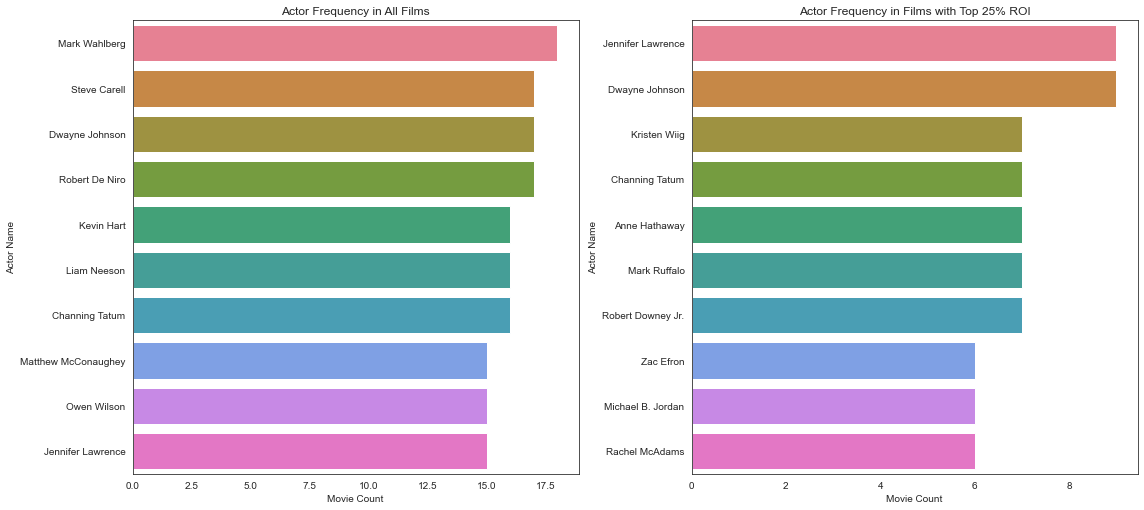

In [177]:
# Plot actor frequency and actor frequency in top ROI next to each other using subplots 

# Apply the default theme
sns.set_style("white")

# Create plot, with 1 row, 2 columns
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,7)) 

# Specify axes, data, orientation, which plot is which, and color
sns.barplot(x = 'frequency', y = 'actors', data = full_actor_df, orient = 'h', ax = ax1, palette='husl')
sns.barplot(x = 'frequency', y = 'actors', data = t25_actor_df, orient = 'h', ax = ax2, palette = 'husl')

# Improve layout 
plt.tight_layout()

# Add a legend and informative axis label
ax1.set(xlabel="Movie Count", ylabel = "Actor Name", 
       title = "Actor Frequency in All Films")

ax2.set(xlabel="Movie Count", ylabel = "Actor Name", 
       title = "Actor Frequency in Films with Top 25% ROI");

These plots show us that `Mark Wahlberg` appears the most frequently in films in our dataset, with `18 films`. The plot on the right shows us that in films with the top 25% ROI, `Dwayne Johnson` and `Jennifer Lawrence` appear the most often, with `9 films`, closely followed by `Robert Downey Jr.`, `Channing Tatum`, `Anne Hathaway`, `Kristen Wiig`, and `Mark Ruffalo`, `all at 7`. Later, we will discuss culture and the impact of time, but is it clear that all of the actors listed in our two plots have had incredibly successful careers thus far, and have contributed to the success and profitability of the films they have appeared in.

#### Which actors generate the highest ROI? How does that compare to those in films in the top 25% ROI?

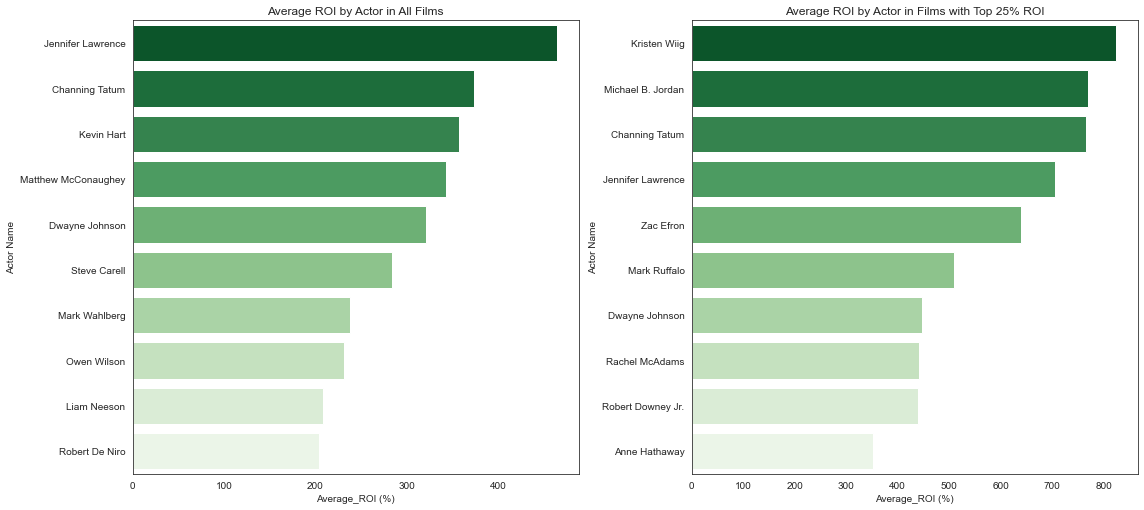

In [178]:
# Plot average actor ROI overall and average actor ROI in top ROI next to each other using subplots 

# Apply the default theme
sns.set_style("white")

# Create plot, with 1 row, 2 columns
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,7)) 

# Specify axes, data, orientation, which plot is which, and color
sns.barplot(x = 'average_ROI', y = 'name', data = df_actor_ROI, orient = 'h', ax = ax1, palette = 'Greens_r')
sns.barplot(x = 'average_ROI', y = 'name', data = df_top_actors, orient = 'h', ax = ax2, palette = 'Greens_r')

# Improve layout 
plt.tight_layout()

# Add a legend and informative axis label
ax1.set(xlabel="Average_ROI (%)", ylabel = "Actor Name", 
       title = "Average ROI by Actor in All Films")

ax2.set(xlabel="Average_ROI (%)", ylabel = "Actor Name", 
       title = "Average ROI by Actor in Films with Top 25% ROI");

These plots are valuable as we use ROI, our measure of success, to quantify the actors and rank them according to our ROI metric. Both of these plots tell us which individual actors have generated the highest return for the films that they have appeared in. `Jennifer Lawrence`, `Channing Tatum` and `Dwayne Johnson` appear in both plots. Although the plot on the right is filtered by just the top 25% ROI, the plot on the left may be even more valuable as it tells us that these actors reign supreme in comparison to their counterparts according to ROI, even when you include films of theirs that may have done poorly. For instance, `Jennifer Lawrence` has generated about `704% return` on films in the top 25% ROI, but when you factor in her poorer performing films, her average ROI still exceeds 400% return, with `464% return`.

#### Which directors from our data have been in the most movies? How does that compare to those in films in the top 25% ROI?

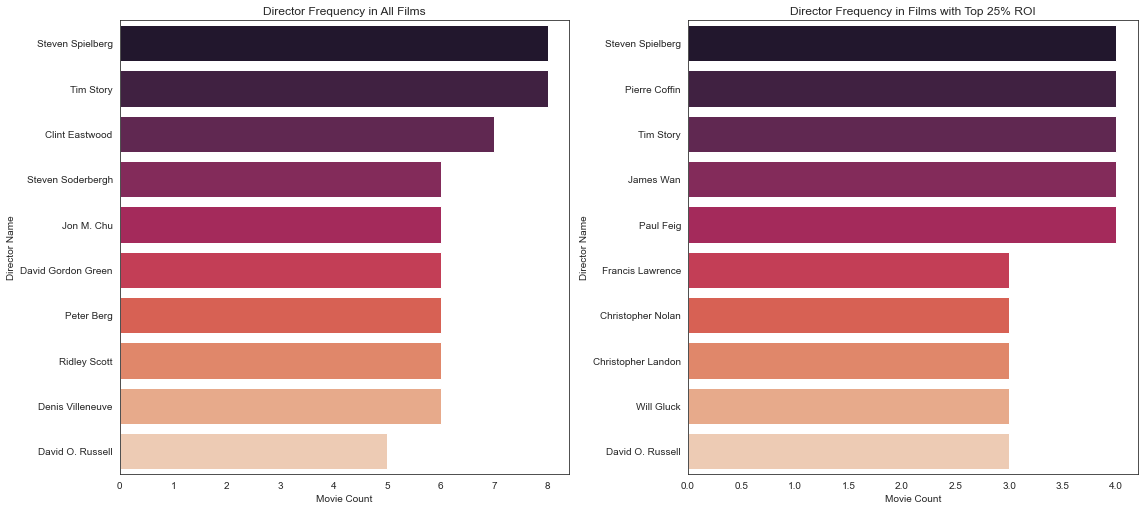

In [179]:
# Plot director frequency and director frequency in top ROI next to each other using subplots 

# Apply the default theme
sns.set_style("white")

# Create plot with 1 row, 2 columns
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,7)) 

# Specify axes, data, orientation, which plot is which, and color
sns.barplot(x = 'frequency', y = 'directors', data = full_director_df, orient = 'h', ax = ax1, palette='rocket')
sns.barplot(x = 'frequency', y = 'directors', data = t25_director_df, orient = 'h', ax = ax2, palette='rocket')

# Improve layout 
plt.tight_layout()

# Add a legend and informative axis label
ax1.set(xlabel="Movie Count", ylabel = "Director Name", 
       title = "Director Frequency in All Films")

ax2.set(xlabel="Movie Count", ylabel = "Director Name", 
       title = "Director Frequency in Films with Top 25% ROI");

These plots tell us that out of all of the films in our dataset, `Steven Spielberg` has directed the most films, with 8. Looking at only films in the top 25% ROI, we see that `Pierre Coffin`, `Steven Spielberg`, `James Wan`, `Tim Story`, and `Paul Feig` have all directed 4 films.

#### Which directors generate the highest ROI? How does that compare to those in films in the top 25% ROI?

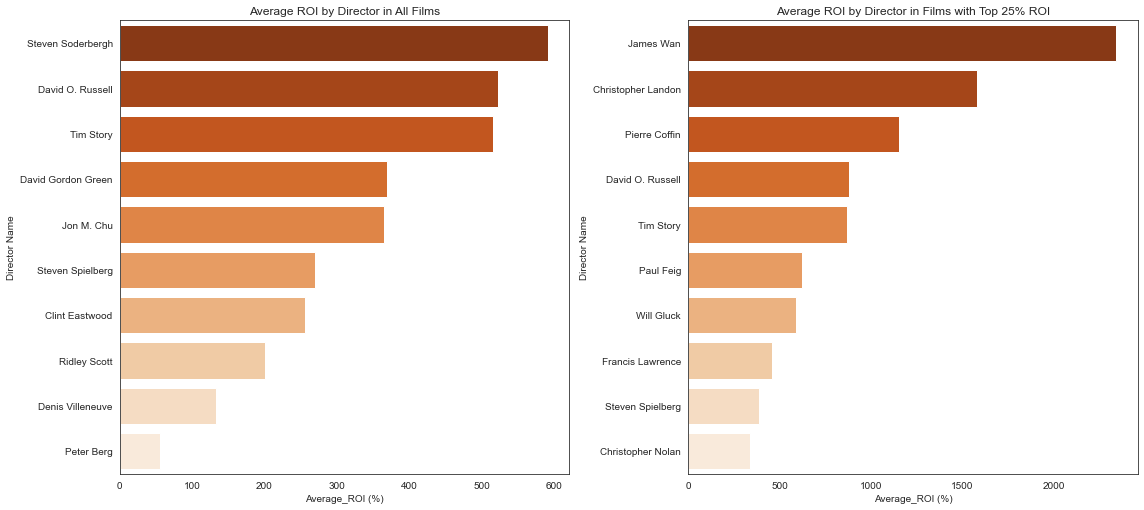

In [180]:
# Plot average director ROI overall and average director ROI in top ROI next to each other using subplots 

# Apply the default theme
sns.set_style("white")

# Create figure with 1 row, 2 columns
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,7)) 

# Specify axes, data, orientation, which plot is which, and palette 
sns.barplot(x = 'average_ROI', y = 'name', data = df_director_ROI, orient = 'h', ax = ax1, palette = 'Oranges_r')
sns.barplot(x = 'average_ROI', y = 'name', data = df_top_directors, orient = 'h', ax = ax2, palette = 'Oranges_r')

# Improve layout 
plt.tight_layout()

# Add a legend and informative axis label
ax1.set(xlabel="Average_ROI (%)", ylabel = "Director Name", 
       title = "Average ROI by Director in All Films")

ax2.set(xlabel="Average_ROI (%)", ylabel = "Director Name", 
       title = "Average ROI by Director in Films with Top 25% ROI");

The plot on the left tells us that `Steven Soderbergh` has generated the highest average ROI out of all directors, in the films he has directors, with a return of `591%`. That being said, we see that he does not appear in the plot on the right, which only shows those films in the top 25% of all ROI. Instead, `James Wan` takes over this category with over `2,341% return`. We can see this is an outlier, and if anything may signal an inconsistent director as `James Wan` does not rank in the top 10 ranked directors by ROI for all films, and may also have directed films with extreme losses. Alternatively, we see directors like `Tim Story`, and `Steven Spielberg` who appear in both lists, indicating both consistency and success. 

#### Which writers from our data have been in the most movies? How does that compare to those in films in the top 25% ROI?

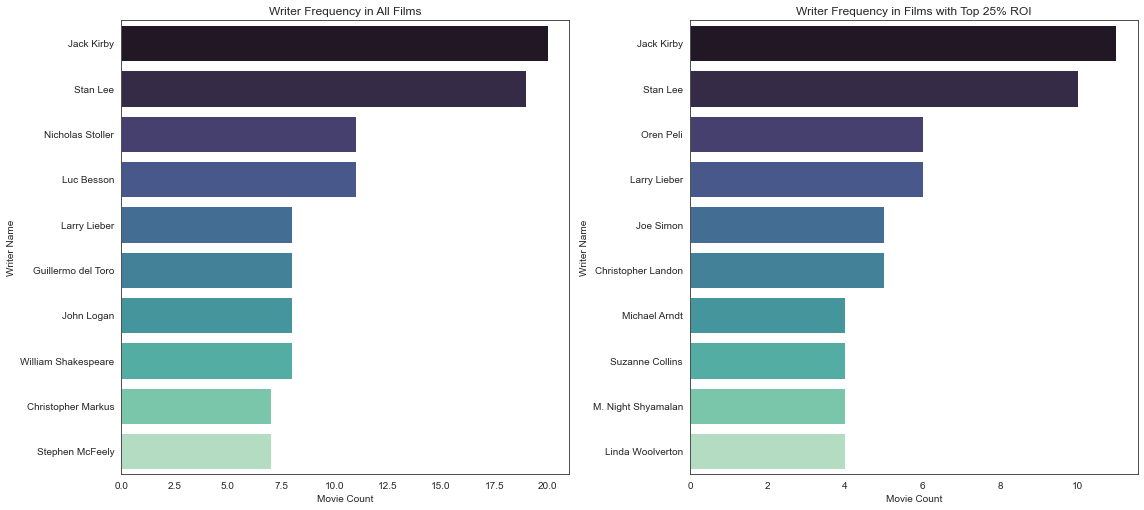

In [181]:
# Plot writer frequency and writer frequency in top ROI next to each other using subplots 

# Apply the default theme
sns.set_style("white")

# Create figure with 1 row, 2 columns
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,7)) 

# Specify axes, data, orientation, which plot is which, and palette
sns.barplot(x = 'frequency', y = 'writers', data = full_writer_df, orient = 'h', ax = ax1, palette='mako')
sns.barplot(x = 'frequency', y = 'writers', data = t25_writer_df, orient = 'h', ax = ax2, palette='mako')

# Improve layout 
plt.tight_layout()

# Add a legend and informative axis label
ax1.set(xlabel="Movie Count", ylabel = "Writer Name", 
       title = "Writer Frequency in All Films")

ax2.set(xlabel="Movie Count", ylabel = "Writer Name", 
       title = "Writer Frequency in Films with Top 25% ROI");

We see that out of all of our films, `Jack Kirby` has written the most with 20 films, followed closely behind by `Stan Lee` with 19 films. In films consisting of only the top 25% ROI, `Jack Kirby` leads the way again with 11 films, followed again by `Stan Lee` with 10 films.

#### Which writers generate the highest ROI? How does that compare to those in films in the top 25% ROI?

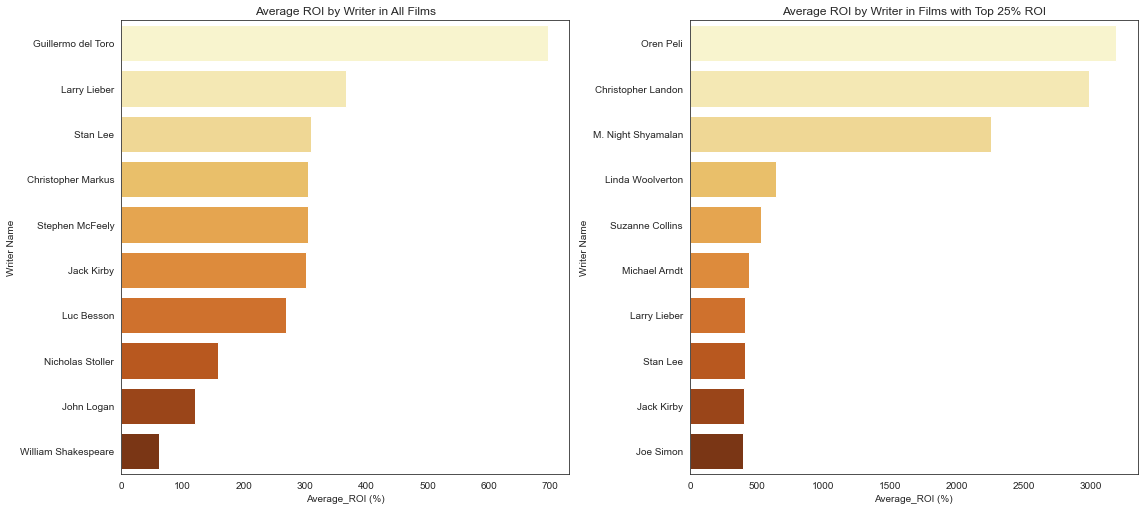

In [182]:
# Plot average writer ROI overall and average writer ROI in top ROI next to each other using subplots 

# Apply the default theme
sns.set_style("white")

# Create figure with 1 row, 2 columns
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,7)) 

# Specify axes, data, orientation, which plot is which, and palette
sns.barplot(x = 'average_ROI', y = 'name', data = df_writer_ROI, orient = 'h', ax = ax1, palette = 'YlOrBr')
sns.barplot(x = 'average_ROI', y = 'name', data = df_top_writers, orient = 'h', ax = ax2, palette = 'YlOrBr')

# Improve layout 
plt.tight_layout()

# Add a legend and informative axis label
ax1.set(xlabel="Average_ROI (%)", ylabel = "Writer Name", 
       title = "Average ROI by Writer in All Films")

ax2.set(xlabel="Average_ROI (%)", ylabel = "Writer Name", 
       title = "Average ROI by Writer in Films with Top 25% ROI");

`Guillermo del Toro` is the writer with the highest overall average ROI at `696% return`. This is interesting since he does not appear in the plot on the right, showing only the highest returns. This may suggest that he has written many successful movies that have surged him to the top, but none of those individual films saw success at the level that we have filtered our ROI by. Seeing `Larry Lieber`, `Stan Lee`, and `Jack Kirby` in both plots is a good indication of success. Finally, we again see the outliers in our top 25% ROI, where `Oren Peli`, `Christopher Landon`, and `M. Night Shyamalan` all generate excessive returns, skewing our data.

## Question Two
### How Are Budget and Worldwide Gross Related?

#### Is There a Relationship Between `production_ budget` and `worldwide_gross`?

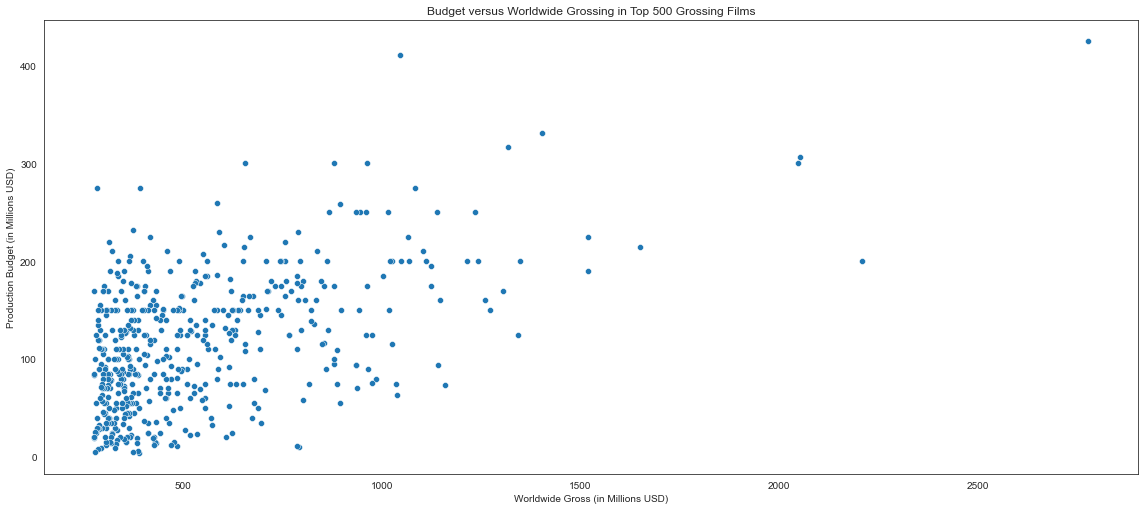

In [183]:
# Let's look at budget versus worldwide gross on a scatterplot

# Apply the default theme
sns.set_style("white")

# Control by millions of USD
wgross = top_budget['worldwide_gross']/1000000
pbud = top_budget['production_budget']/1000000

# Create plot
fig, ax = plt.subplots(figsize=(16,7)) 

# Specify axes and data
sns.scatterplot(x = wgross, y = pbud, data = top_budget)

# Improve layout 
plt.tight_layout()

# Add a legend and informative axis label
ax.set(xlabel="Worldwide Gross (in Millions USD)", ylabel = "Production Budget (in Millions USD)", 
       title = "Budget versus Worldwide Grossing in Top 500 Grossing Films");

Just looking at the scatterplot shows us that we have a lot of data points clustered to the left of the plot, with a low worldwide gross and a range of budgets. In general, as the worldwide gross increases, the budget looks like it increases as well, in a positive relationship. 

In [184]:
# Look at correlation numbers 

top_budget.corr()

,production_budget,domestic_gross,worldwide_gross,worldwide_net_profit,domestic_net_profit,worldwide_ROI,domestic_ROI
production_budget,1.000000,0.351181,0.528726,0.334221,-0.254868,-0.496339,-0.460537
domestic_gross,0.351181,1.000000,0.854053,0.859531,0.815882,0.112457,0.161328
worldwide_gross,0.528726,0.854053,1.000000,0.976694,0.555511,0.004719,-0.032423
worldwide_net_profit,0.334221,0.859531,0.976694,1.000000,0.681285,0.130751,0.080456
domestic_net_profit,-0.254868,0.815882,0.555511,0.681285,1.000000,0.422656,0.451017
worldwide_ROI,-0.496339,0.112457,0.004719,0.130751,0.422656,1.000000,0.949989
domestic_ROI,-0.460537,0.161328,-0.032423,0.080456,0.451017,0.949989,1.000000


The correlation coefficient between `production_budget` and `worldwide_gross` is `.53`. This aligns with our scatterplot above where there is a positive relationship between the two variables, but it is not jaw dropping. First we will look at the budget distribution of the highest vs. lowest grossing films. Then we will turn our budget column into a categorical variable to look at which budget ranges may help Microsoft gain the most potential revenue.

#### What do the Distributions of Top 500 Grossing and Bottom 500 Grossing Films Look Like?

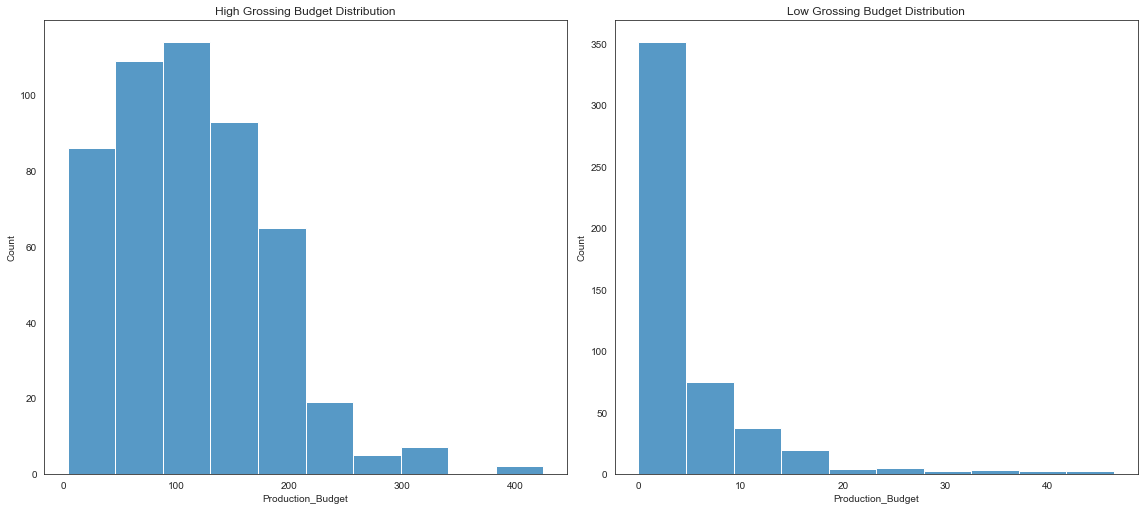

In [185]:
# Look at histogram for the two budget categories

# Create figure with 1 row, 2 columns
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,7))

# Control by millions of USD
tgross = top_budget['production_budget']/1000000
bgross = bottom_budget['production_budget']/1000000

# Specify axes, data, which plot is which, and bins
sns.histplot(x = tgross, ax = ax1, bins=10)
sns.histplot(x = bgross, ax = ax2, bins=10)

# Improve layout 
plt.tight_layout()

# Add a legend and informative axis labels
ax1.set(xlabel="Production_Budget", 
       title = "High Grossing Budget Distribution")

ax2.set(xlabel="Production_Budget", 
       title = "Low Grossing Budget Distribution");

The scale of the x-axis inthe two histograms vary significantly. That being said, it is even more apparent that the distribution of of budget for the 500 highest grossing films follows more of a normal pattern than that of the 500 lowest grossing films, which is skewed significantly to the right. Both groups of data have significant outliers. For the high grossing films, we see that the majority of budgets sit in the 50-200 million range, whereas that for the low grossing films its between 0-5 million. With that being said, we will dig deeper into the top 500 grossing films.

We already created bins for our budget range so let's look at a box and whisker plot to look at the distribution.

#### What is the distribution between `production_budget` , by bin, and `worldwide_gross`?

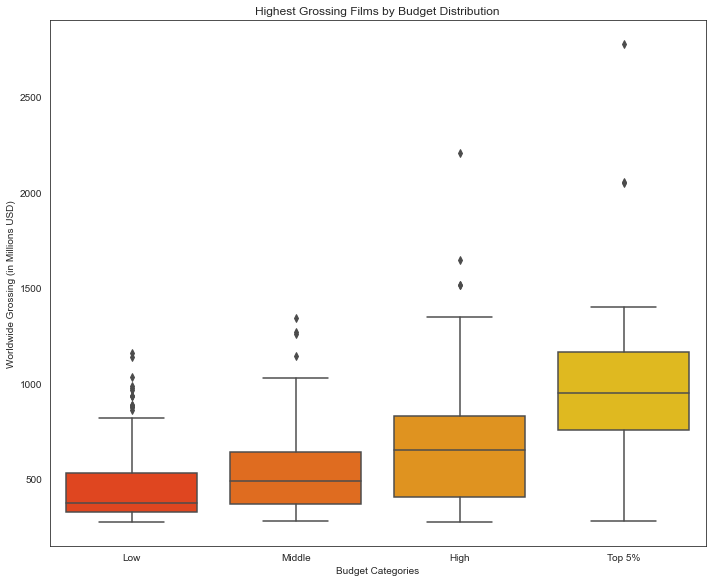

In [186]:
# Create plot
fig, ax = plt.subplots(figsize=(10, 8))

# Control by millions of USD
wgross = top_budget['worldwide_gross']/1000000

# Specify axes, data, and palette
sns.boxplot(x='budget_bins', y=wgross, data = top_budget, palette="autumn")
                                  
# Improve layout 
plt.tight_layout()

# Add a legend and informative axis label
ax.set(xlabel="Budget Categories", ylabel= 'Worldwide Grossing (in Millions USD)',
       title = "Highest Grossing Films by Budget Distribution");
 

Before analyzing, let's look at the exact same plot without outliers.

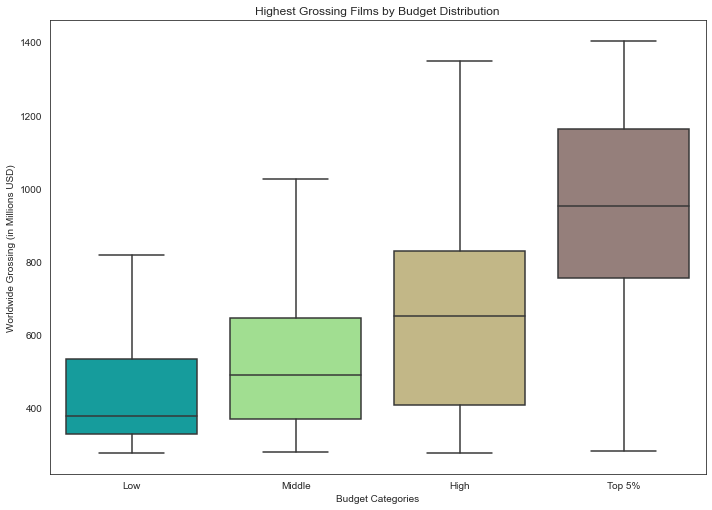

In [187]:
# Create plot
fig, ax = plt.subplots(figsize=(10, 7))

# Control by millions of USD
wgross = top_budget['worldwide_gross']/1000000

# 'showfliers = False' will remove outliers
sns.boxplot(x='budget_bins', y=wgross, data = top_budget, palette="terrain", showfliers = False)
                                  
# Improve layout 
plt.tight_layout()

# Add a legend and informative axis label
ax.set(xlabel="Budget Categories", ylabel= 'Worldwide Grossing (in Millions USD)',
       title = "Highest Grossing Films by Budget Distribution");

It's interesting to see that the `Top 5%` of `production_budget` values has the fewest films, but the highest median, at about `267.5 million`. The entire interquartile range is shifted above that of our `Low` and `Middle` bins. This indicates that once you hit a particular budget point, the grossing compounds. The separation looks to take place around that point near `267.5 million`. That being said, our `Low`, `Middle`, and `High` bins do not have the same dramatic differences that we see for the `Top 5%`. In fact, we may be seeing that the benefits of spending more money on budget prior to the `median` value for our `Top 5` bin may not impact grossing significantly at all. This would be a worthwhile insight to share with Microsoft. We will glance at this below.

In [188]:
# Group dataframe by bins and control for scientific notation to see box and whisker values

top_budget.groupby(['budget_bins'])['worldwide_gross'].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,count,mean,std,min,25%,50%,75%,max
budget_bins,,,,,,,,
Low,126.00000,471246241.38095,209722262.67235,276014965.00000,328938768.00000,376943790.00000,532681270.25000,1160336173.00000
Middle,125.00000,544765613.80000,228249860.93743,280355920.00000,370098020.00000,490875846.00000,644602516.00000,1341693157.00000
High,94.00000,694222791.41489,349115811.58020,276928112.00000,406808645.00000,652173957.00000,827990487.50000,2208208395.00000
Top 5%,24.00000,1051603287.87500,570091364.21653,282778100.00000,755167155.00000,952972238.00000,1163763626.50000,2776345279.00000


Above, we can take a closer look at the values shown in the box and whisker plot. Below is a reference point to remind ourselves of the spread of the data within each of our budget bins. 

In [189]:
# Group dataframe by bins and control for scientific notation to see budget bins info

top_budget.groupby(['budget_bins'])['production_budget'].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,count,mean,std,min,25%,50%,75%,max
budget_bins,,,,,,,,
Low,126.00000,88579385.86508,12946533.96208,67500000.00000,76500000.00000,87750000.00000,100000000.00000,110000000.00000
Middle,125.00000,138349600.00000,13479887.19202,111000000.00000,125000000.00000,140000000.00000,150000000.00000,160000000.00000
High,94.00000,188367021.27660,16833973.51044,165000000.00000,175000000.00000,185000000.00000,200000000.00000,225000000.00000
Top 5%,24.00000,282258333.33333,50530799.18888,230000000.00000,250000000.00000,267500000.00000,300000000.00000,425000000.00000


Create a bar plot below to look at the bins in a different format.

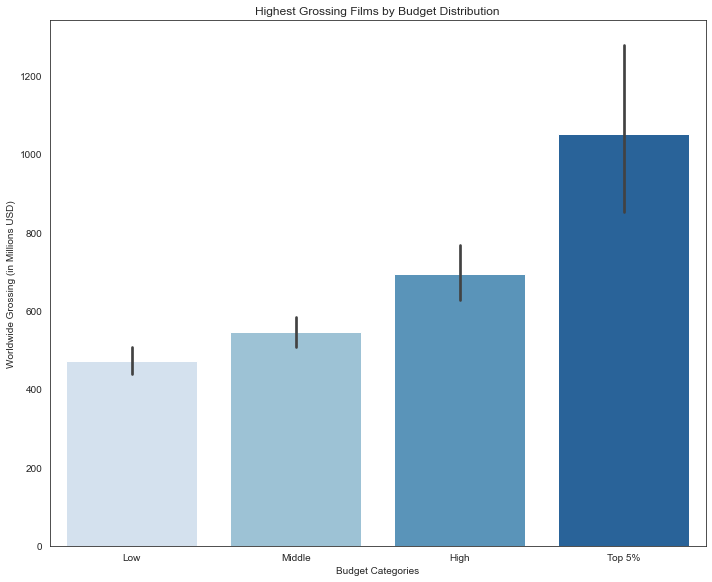

In [190]:
# Create bar plot

# Create plot
fig, ax = plt.subplots(figsize=(10, 8))

# Control by millions of USD
wgross = top_budget['worldwide_gross']/1000000

# Add axes, data, and palette
sns.barplot(x='budget_bins', y=wgross, data = top_budget, palette="Blues")
                                  
# Improve layout 
plt.tight_layout()

# Add a legend and informative axis label
ax.set(xlabel="Budget Categories", ylabel= 'Worldwide Grossing (in Millions USD)',
       title = "Highest Grossing Films by Budget Distribution");

## Question Three
### What Other Trends Impact ROI?

#### Which month are the most movies released? Which month within the Top 10% of ROI? Which month generates the highest average ROI?

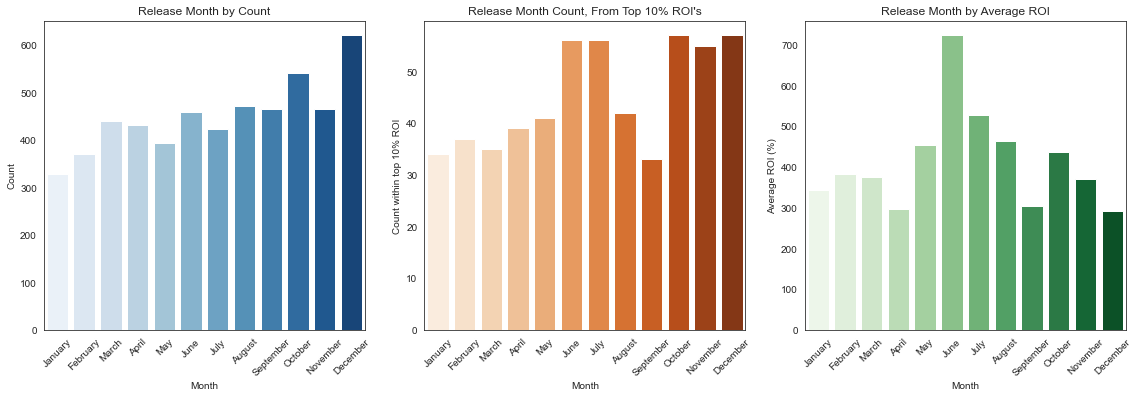

In [191]:
# Create three plots 

# Apply the default theme
sns.set_style("white")

# Create plot with 1 row, 3 columns
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5)) 

# Organize month order 
months = ['January', 'February', 'March', 'April', 'May', 'June',  'July',
          'August', 'September', 'October', 'November', 'December']

# Specify axes, data, which plot is which, palette, and month order
sns.barplot(x = 'months', y = 'frequency', data = full_month_df, ax = ax1, palette = 'Blues', order=months)
sns.barplot(x = 'release_month', y = 'worldwide_ROI', data = top_months, ax = ax2, palette = 'Oranges', order=months)
sns.barplot(x = 'release_month', y = 'worldwide_ROI', data = roi_by_month, ax = ax3, palette = 'Greens', order=months)

# Improve layout 
plt.tight_layout()

# Rotate x axis labels for readability 
ax1.tick_params(axis='x', labelrotation=45)
ax2.tick_params(axis='x', labelrotation=45)
ax3.tick_params(axis='x', labelrotation=45)

# Add a legend and informative axis label
ax1.set(xlabel="Month", ylabel = "Count", 
       title = "Release Month by Count")

ax2.set(xlabel="Month", ylabel = "Count within top 10% ROI", 
       title = "Release Month Count, From Top 10% ROI's")

ax3.set(xlabel="Month", ylabel = "Average ROI (%)", 
       title = "Release Month by Average ROI");

This data is interesting as the most common release month in all films is `December`, however, the most common release month in the films that performed with the highest 10% of returns is tied at `December` and `October` with 57 films, followed very closely behind by `July` and `June` with 56 films. Although these trends are valuable, they do not factor in our ROI, which is how we are measuring film success. The bar plot on the far right shows us that films that are released in `June` far exceed films released in any other month when looking at average ROI generated. In fact, the next highest month by ROI is `July`, which sees returns that are nearly 200% fewer than that of June.

#### How is the runtime data distributed? How does this data relate to ROI?

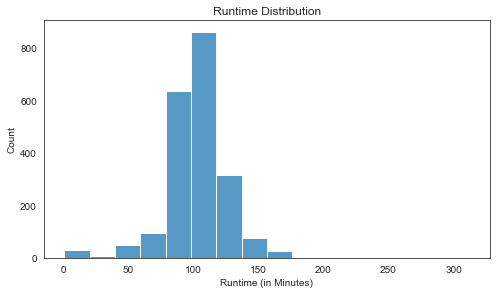

In [192]:
# Look at histogram to see distribution 

# Create plot
fig, ax = plt.subplots(figsize=(7,4))

# Specify axes, data, and bins
sns.histplot(x = 'runtime_minutes', data = runtime_df, bins=16)

# Improve layout 
plt.tight_layout()

# Add a legend and informative axis label
ax.set(xlabel="Runtime (in Minutes)", 
       title = "Runtime Distribution");

We see above that the runtime data is relatively normal, centered around 100 minutes. 

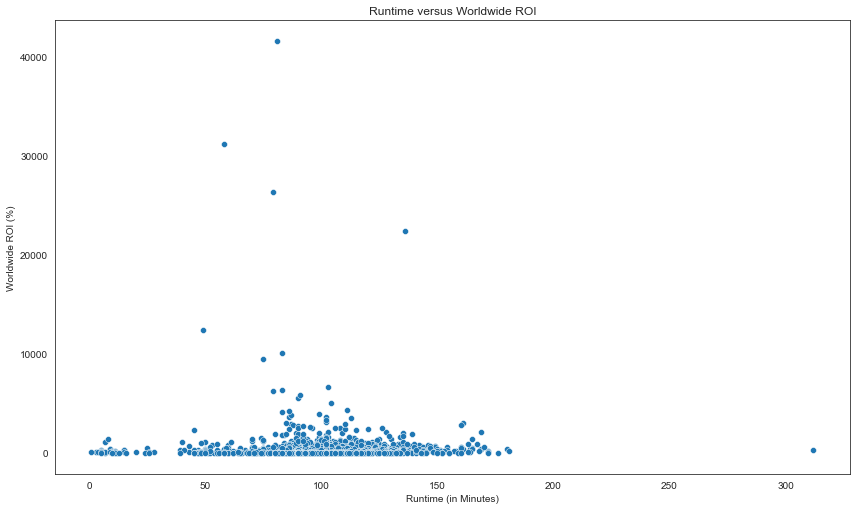

In [193]:
# Look at runtime versus ROI in scatterplot

# Create plot
fig, ax = plt.subplots(figsize=(12, 7))

# Specify axes and data 
sns.scatterplot(x= 'runtime_minutes', y= 'worldwide_ROI', data = runtime_df)

# Improve layout 
plt.tight_layout()

# Add a legend and informative axis label
ax.set(xlabel="Runtime (in Minutes)", ylabel = "Worldwide ROI (%)", 
       title = "Runtime versus Worldwide ROI");



We can see the basic relationship here, where we have outliers, but can see that the majority of films are concentrated around the 100 minute mark, where our markers shift in height and we can see an ROI increase surrounding that minute mark. We will split our ROI data into bins, and look at how that distribution relates to runtime in more detail below.

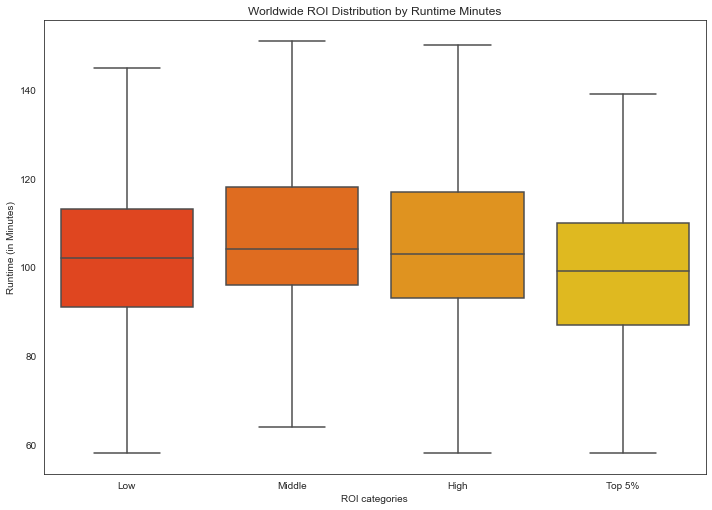

In [194]:
# Use ROI bins to create a box and whisker plot

# Create plot
fig, ax = plt.subplots(figsize=(10, 7))

# Add axes, data, palette, and remove outliers 
sns.boxplot(x='ROI_bins', y='runtime_minutes', data = runtime_df, palette="autumn", showfliers=False)
                                  
# Improve layout 
plt.tight_layout()

# Add a legend and informative axis label
ax.set(xlabel="ROI categories", ylabel= 'Runtime (in Minutes)',
       title = "Worldwide ROI Distribution by Runtime Minutes");

We see that the runtime minutes revolve around the 100 minute mark. There is a slight shift in interquartile range and median for each ROI category. What is most significant is that the IQR for the top 5% of our ROI has the shortest runtime minutes, with a median of `99 minutes`. Our other ROI categories are all `102 minute or higher`. There are few films that are longer than `110-118 minutes` according to our 75th quartile. There are also few films shorter than `87-96 minutes` according to our 25th quartile. This will help us be more precise when making a runtime recommendation to Microsoft.

In [195]:
# Group dataframe by bins and control for scientific notation to see box and whisker values

runtime_df.groupby(['ROI_bins'])['runtime_minutes'].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,count,mean,std,min,25%,50%,75%,max
ROI_bins,,,,,,,,
Low,524.00000,101.18702,23.01416,1.00000,91.00000,102.00000,113.00000,172.00000
Middle,524.00000,105.67176,24.00811,5.00000,96.00000,104.00000,118.00000,312.00000
High,419.00000,105.19809,22.71619,7.00000,93.00000,103.00000,117.00000,170.00000
Top 5%,105.00000,99.64762,23.40980,8.00000,87.00000,99.00000,110.00000,169.00000


In [196]:
# Group dataframe by bins and control for scientific notation to see ROI bin info 

runtime_df.groupby(['ROI_bins'])['worldwide_ROI'].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,count,mean,std,min,25%,50%,75%,max
ROI_bins,,,,,,,,
Low,524.00000,31.28134,36.21394,-27.56929,0.39663,31.68428,61.65694,98.43852
Middle,524.00000,186.74200,56.07139,98.63536,137.45744,176.77871,231.73592,295.22899
High,419.00000,543.98978,209.23706,295.57043,372.66200,482.99800,686.88705,1080.87991
Top 5%,105.00000,3478.43254,5861.61432,1082.33405,1300.14973,1853.44516,2824.26023,41556.47400


#### Which studio has released the most films? Which within the Top 10% of ROI? Which studio generates the highest average ROI?

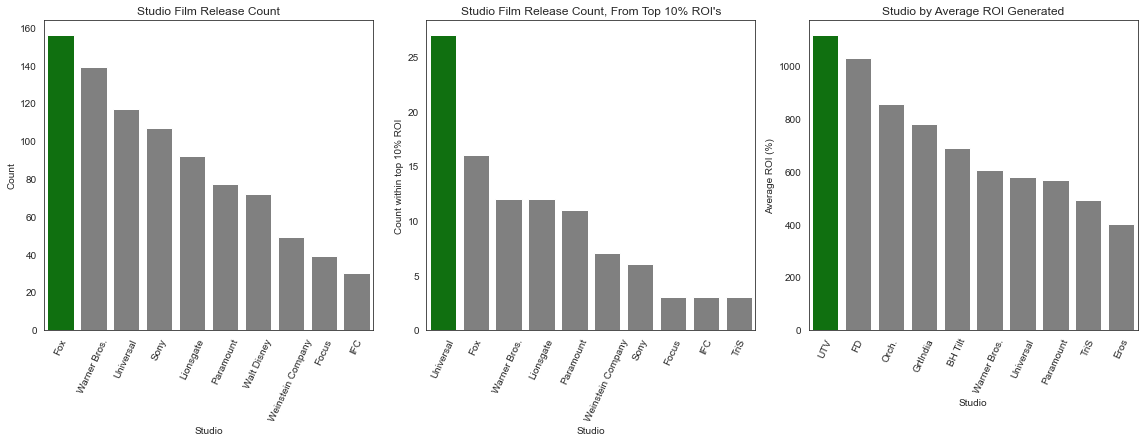

In [197]:
# Create 3 plots

# Create loop for color to highlight highest value
v1 = studio_count_df['frequency']
c1 = ['grey' if (x < max(v1)) else 'green' for x in v1]

v2 = top_studio['worldwide_ROI']
c2 = ['grey' if (x < max(v2)) else 'green' for x in v2]

v3 = roi_by_studio['worldwide_ROI']
c3 = ['grey' if (x < max(v3)) else 'green' for x in v3]

# Create 1 row, 3 columns
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5)) 

# Specify axes, data, which plot is which, and palette
sns.barplot(x = 'studio', y = 'frequency', data = studio_count_df, ax = ax1, palette = c1)
sns.barplot(x = 'studio', y = 'worldwide_ROI', data = top_studio, ax = ax2, palette = c2)
sns.barplot(x = 'studio', y = 'worldwide_ROI', data = roi_by_studio, ax = ax3, palette = c3)

# Improve layout 
plt.tight_layout()

# Rotate x axis labels
ax1.tick_params(axis='x', labelrotation=65)
ax2.tick_params(axis='x', labelrotation=65)
ax3.tick_params(axis='x', labelrotation=65)

# Add a legend and informative axis label
ax1.set(xlabel="Studio", ylabel = "Count", 
       title = "Studio Film Release Count")

ax2.set(xlabel="Studio", ylabel = "Count within top 10% ROI", 
       title = "Studio Film Release Count, From Top 10% ROI's")

ax3.set(xlabel="Studio", ylabel = "Average ROI (%)", 
       title = "Studio by Average ROI Generated");

We see that `Fox` studio has produced and/or distributed the highest number of films in our data, historically, with `156 films`. Fox is followed closely behind by `Warner Bros.` studios. For those films with the top 10% ROI, we see that `Universal` studios outperforms all other studios with `27 films`. The next closest competitor is `Fox` who comes in with `16 films`. Looking at which studio has produced the highest average ROI historically, `UTV` Motion Pictures comes in with over `1,000% return`, followed by `FD - FilmDistrict` also over `1,000% return`. 

In [198]:
# We notice the studios in our third plot vary from our other two, let's look at this for our evaluation

# Pull up films by studio to look closer at the lesser known studios
bom_df.loc[bom_df['studio'] == 'Eros'].head()

,studio
movie,
Dabangg,Eros
Housefull,Eros
Golmaal 3,Eros
Anjaana Anjaani,Eros
Khatta Meetha,Eros


## Evaluation

***
We looked at our models above, by question, and evaluated each question individually to come up with separate recommendations to Microsoft. 

#### Question One

For **actors, directors and writers**, the bar plots helped us look at how often individuals have appeared in films and the making of them over time, and how that compares to the returns they have helped generate. We are making our recommendation based on the personnel with the highest ROI in all films, as well as specifically those films with the top 25% returns. We see there is a lot of overlap here, which makes us even more confident in these recommendations. One thing we will be mindful of, is that a specific actor, director, or writer is not a solve all and should not be the only focus when creating films. That being said, our data and analysis makes it abundantly clear that having high quality actors, directors, and writers is likely to lead to a profitable film and high returns. It is no accident that many of these figures are household names, and no surprise that the numbers further validate their reputations. 

We will be crystal clear in communicating to Microsoft that there will be many other actors, directors, and writers who have the potential to create successful films. That being said, we will recommend Microsoft consider casting **`Kristen Wiig`, `Channing Tatum`, `Dwayne Johnson`, and `Jennifer Lawrence`**. We selected these actors based on their overall and top ROI’s, where we saw a lot of overlap. We will recommend Microsoft considers directors **`Steven Soderbergh`, `James Wan`, `Steven Spielberg`, and `Tim Story`,**, all selected by their ROI. For directors and writers, we focused more on overall average ROI rather than just in the top 25%. We did this because we felt since there was not a lot of overlap, we would be more confident recommending directors and writers to Microsoft who have seen the most returns overtime, inlcuding in their lesser performing films, rather than just looking at their successful moments. With that being said, we will recommend that Microsoft looks to writers **`Guillermo del Toro`, `Oren Peli`, `Larry Lieber`, and `Stan Lee`**, all selected from our ROI calculations. 
***
#### Question Two

For **production budget**, we looked at a scatterplot to see the correlation between budget and worldwide gross. We saw a positive but not incredibly strong relationship there. This helped us decide to narrow down our models a bit, and split the data based on high and low grossing films. We looked at the distribution of the two categories in histograms. Knowing our goal is to help Microsoft bring in as much money as possible, we decided to narrow in on the highest grossing films, searching for any budget patterns in that data. The box and whisker plot helped us look at the budget bins we created, the grossing distribution among those bins. We also looked at this in a bar plot, which was repetitive but helpful to see in another format. Overall, our box and whisker plot helped lead us to our precise budget recommendation.

We saw that by increasing a budget of about 67.5-110 million USD, to 111-160 million the median gross only increases about 100 million. (From 377-490 million). That is not to say this is insignificant, but when looking at returns, you are on average increasing the budget by 100 million and getting 100 million back. The same holds true when you increase the budget from 111 million-160 million, to 168-225 million, the median gross increases from 645-828 million. We saw in our highest budget bins, by increasing the budget from 165-225 million to 230-425 million, the median gross increases from 652 million to 926 million. Again, significant returns, but on a similar scale. 

Finally, increasing the budget from **268-300 million leads to a grossing increase from 953-1,164 million** and **increasing the budget from 300-425 million leads to a grossing increase from 1,164-2,776 million**. These numbers are much more significant. In the last example, we only increase the budget by 125 million, but our gross increases nearly 13 times that at 1,612 million dollars. With this information, we will inform Microsoft that increasing budget in the range of **68-268 million** is likely to see returns on a similar scale, not far from 1:1. However, once you **increase the budget beyond 268 million**, the rate of return may begin to increase dramatically.

***
#### Question Three

For **release month**, the bar plots helped us easily compare the frequency of occurrence and average ROI of each month. Although the overall count of occurrences is important, we saw that December was the most common release month, but was low when it came to generating ROI. However, when it came to looking only at occurrences of films that were in the top 10% of returns, June sneaks in there, as well as July, October, and December. Once we took it one step further, only looking at average ROI per month, **June came out on top**. **This is the month that we will recommend to Microsoft**, seeing as our measure of success is ROI, and on average, releasing a film in June has historically seen over a 700% return on average. We want to equip Microsoft with as thorough and comprehensive of a recommendation as possible. Because of this we will mention that after June, we recommend releasing films in **July, October, and December**, in respective order.

For **runtime**, the histogram and scatterplot were helpful, but only looked at the runtime data on its own. These plots helped us decide to bin our ROI data to get a better look at how runtime spread among different categories of return for films. **We will recommend the range of runtime minutes** from the 50%-75% percentiles of the Top 5% of our data. This is the **range of 99-110 minutes**. We will advise Microsoft **not dip below 99 minutes**, and if anything **let runtime run up until 118 minutes**, but not above that point. 118 minutes is the longest runtime that we see at the 75% runtime mark of our bins. By doing this, we are also including the runtime metrics that we see in 50% of all other bins of our data, so we can be confident that these runtimes have historically and will continue to lead to high returns on films. 

For **studio**, we saw that when we looked at average ROI, instead of studio counts, our recommendation would change significantly. Looking closer at studios with the highest average ROI, we saw many of them are international studios. Emulating the practices of international studios may not provide Microsoft with the best environment to be successful domestically. For instance, UTV is known as Walt Disney Studio Films in India. Earlier, we grouped many of the obvious studio labels together, but also did not want to skew the data grouping labels that may have been less appropriate. Now we know that:

* `the Orchard` is a subsidiary of `Sony`, and `Tristar Pictures` is a member of the `Sony Motion Picture Group`. 
* `GrtIndia` only has one film in our data, with a sample size of one, this is not a studio we would recommend to Microsoft. 
* `BH Tilt`, known as Blumhouse Production, has produced Paranormal Activity, Insidious, The Purge, etc. This is a production company specializing in a particular genre (Haunted), so again, we would be mindful recommending this to Microsoft. 
* `Eros` is an Indian motion picture production and distribution company, they have generated a very high return over time, but again, we would be mindful advising Microsoft to use international studios. 

Because of this analysis, our studio recommendation focuses on the overlap of studios in our studio count by top 10% ROI and the average ROI of those studios in our plots. This leaves us recommending Microsoft look to studios, studio members, and studio subsidiaries of **Universal, Warner Brothers, Paramount, and Sony.** 

## Conclusions and Recommendations 

Now that we have evaluated all the data, we can list out our actionable recommendations. We will be able to provide Microsoft with these recommendations, advising the company with how best to proceed with its venture into the video content industry.
*** 

Our first question involved us analyzing actors, directors, and writers. We recommend:
* Considering casting **Kristen Wiig, Channing Tatum, Dwayne Johnson, and Jennifer Lawrence**
* Considering directors **Steven Soderbergh, James Wan, Steven Spielberg, and Tim Story**
* Considering writers **Guillermo del Toro, Oren Peli, Larry Lieber, and Stan Lee**

***

Our second question involved us exploring production budget values that have been historically successful. We recommend:
* Keeping the budget in the range of **68-268 million USD**
* **OR** increasing the budget above **268 million USD**

***

Our third question aimed to see how other characteristics of movies may lead to a higher return on investment. We recommend: 
* Releasing films in **June**, followed by **July, October, and December**
* Limiting films to a runtime of **99-110 minutes**, **no shorter than 99 minutes and no longer than 118 minutes**
* Emulating **Universal, Warner Brothers, Paramount, and Sony** studios


#### Citations Referenced

* https://stackoverflow.com/questions/37625334/python-pandas-convert-month-int-to-month-name
* https://stackoverflow.com/questions/13035764/remove-pandas-rows-with-duplicate-indices
* https://stackoverflow.com/questions/47164362/what-does-a-symbol-do
* https://stackoverflow.com/questions/35939552/pandas-using-the-tilde-operator-to-return-inverse-data-with-two-filters
* https://stackoverflow.com/questions/35939552/pandas-using-the-tilde-operator-to-return-inverse-data-with-two-filters
* https://stackoverflow.com/questions/43175382/python-create-a-pandas-data-frame-from-a-list
* https://stackoverflow.com/questions/49382207/how-to-map-numeric-data-into-categories-bins-in-pandas-dataframe